# Imports

In [1]:
import pandas as pd

# from mltools.io import PreparedDataManager
from mltools.io import DatasetManager
from mltools.io import PredictionDataManager
from mltools.io import PreparedDataManager
# from mltools.reporting import MetricsTable

from mltools.models import ModelLoader
from mltools.training.observation_builder import get_observations_from_tl

from mltools.evaluation.tasks import DischargeEvaluator
from scripts_files.apply_platt_scaling import fit_platt_scaling
from scripts_files.calibration_plot import calibration_plot
from pathlib import Path
from scripts_files.calibration_plot import display_calibration_plot

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import *
# chi2_contigency

In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
STATISTICAL_SIGNIFICANCE = 0.05

# Load

## Model

In [4]:
use_case = 'aki_kdigo'

In [5]:
# 	*original model*
# 	trained with aki_kdigo_train_tl.feather
# 	1672087900, 1672108814
	
# 	*trained with data from 2018*
# 	trained with aki_kdigo_train_2018_tl.feather
# 	1672191910,1672203276

model = ModelLoader.load(use_case, 1677190694)
model

aki_kdigo TransformerModel (1677190694)

In [6]:
model.thresholds

{'medium': 0.5,
 'high': 0.75,
 'sens90': 0.13360098014957147,
 'spec95': 0.4639576506125965,
 'spec90': 0.3131670000555229,
 'ppv10': 0.007387708312119441,
 'ppv25': 0.007387708312119441,
 'specific': 0.007387708312119441,
 'specific_high': 0.026169105678708532}

## Test Data

In [7]:
dm = DatasetManager()
pdm = PreparedDataManager()
male_test_data = dm.reader().read(f'{use_case}_test_male_tl')
female_test_data = dm.reader().read(f'{use_case}_test_female_tl')

In [8]:
female_test_data.drop_duplicates('CASEID').groupby('LABEL').CASEID.count()

LABEL
False    8732
True     3030
Name: CASEID, dtype: int64

In [9]:
male_test_data.drop_duplicates('CASEID').groupby('LABEL').CASEID.count()

LABEL
False    15715
True      5728
Name: CASEID, dtype: int64

## Threshold Data split

In [10]:
dataset = 'test'
thr_data = dm.reader().read(f'{use_case}_{dataset}_tl').reset_index()
adm_df = pdm.reader().read('admissions_all')
writer = dm.writer()

caseids = adm_df[adm_df.ADMISSION_DATE.dt.year>2017].CASEID
thr_complete_df = thr_data[thr_data.CASEID.isin(caseids)]
# Save the dataset
writer.write(thr_complete_df, f'{use_case}_{dataset}_2018_tl')

male_ids = thr_complete_df[thr_complete_df.FEATURE.str.contains('GENDER-MALE')].CASEID
thr_2018_male_df = thr_complete_df[thr_complete_df.CASEID.isin(male_ids)]
# Save the dataset
writer.write(thr_2018_male_df, f'{use_case}_{dataset}_2018_male_tl')

female_ids = thr_complete_df[thr_complete_df.FEATURE.str.contains('GENDER-FEMALE')].CASEID
thr_2018_female_df = thr_complete_df[thr_complete_df.CASEID.isin(female_ids)]
# Save the dataset
writer.write(thr_2018_female_df, f'{use_case}_{dataset}_2018_female_tl')

print('Female: ',len(female_ids),', Male: ', len(male_ids),', Total: ', len(female_ids) + len(male_ids))

Female:  11762 , Male:  21443 , Total:  33205


# Predictions

In [11]:
male_thr_data = dm.reader().read(f'{use_case}_thr_2018_male_tl')
female_thr_data = dm.reader().read(f'{use_case}_thr_2018_female_tl')
thr_data = dm.reader().read(f'{use_case}_thr_2018_tl').reset_index()
male_test_data = dm.reader().read(f'{use_case}_test_2018_male_tl')
female_test_data = dm.reader().read(f'{use_case}_test_2018_female_tl')
test_data = dm.reader().read(f'{use_case}_test_2018_tl').reset_index()

In [12]:
#from 2018 on threshold complete
observations, labels, caseids = get_observations_from_tl(thr_data)
y_pred = model.predict(observations)

thr_pred = pd.DataFrame(
    zip(caseids, labels, y_pred, observations),
    columns=['CASEID', 'LABEL', 'PREDICTION','OBS'])

#from 2018 on test complete
observations, labels, caseids = get_observations_from_tl(test_data)
y_pred = model.predict(observations)

test_pred = pd.DataFrame(
    zip(caseids, labels, y_pred, observations),
    columns=['CASEID', 'LABEL', 'PREDICTION','OBS'])

print('threshold set: ', thr_pred.CASEID.nunique(), ', test set: ', test_pred.CASEID.nunique())

1038/1038 [==============================] - 274s 264ms/step
threshold set:  2988 , test set:  33205


In [13]:
#from 2018 on threshold male
observations, labels, caseids = get_observations_from_tl(male_thr_data)
y_pred = model.predict(observations)

thr_male_pred = pd.DataFrame(
    zip(caseids, labels, y_pred, observations),
    columns=['CASEID', 'LABEL', 'PREDICTION','OBS'])

#from 2018 on test male
observations, labels, caseids = get_observations_from_tl(male_test_data)
y_pred = model.predict(observations)

male_pred_df = pd.DataFrame(
    zip(caseids, labels, y_pred, observations),
    columns=['CASEID', 'LABEL', 'PREDICTION','OBS'])

print('threshold male set: ', thr_male_pred.CASEID.nunique(), ', test male set: ', male_pred_df.CASEID.nunique())

671/671 [==============================] - 179s 266ms/step
threshold male set:  2192 , test male set:  21443


In [14]:
#from 2018 on threshold female
observations, labels, caseids = get_observations_from_tl(female_thr_data)
y_pred = model.predict(observations)

thr_female_pred = pd.DataFrame(
    zip(caseids, labels, y_pred, observations),
    columns=['CASEID', 'LABEL', 'PREDICTION','OBS'])

#from 2018 on test female
observations, labels, caseids = get_observations_from_tl(female_test_data)
y_pred = model.predict(observations)

female_pred_df = pd.DataFrame(
    zip(caseids, labels, y_pred, observations),
    columns=['CASEID', 'LABEL', 'PREDICTION','OBS'])

print('threshold female set: ', thr_female_pred.CASEID.nunique(), ', test female set: ', female_pred_df.CASEID.nunique())

368/368 [==============================] - 97s 265ms/step
threshold female set:  796 , test female set:  11762


# Statistical Calibration

### Calibrate using both genders

In [15]:
# APPLY PLATT SCALING
# FIT PLATT SCALING ON CALIBRATION DATA
platt_scaling = fit_platt_scaling(thr_pred)

## TRANSFORM
thr_pred_both = thr_pred.copy()
thr_pred_both['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(thr_pred_both.PREDICTION))
thr_pred_both['data']='CALIB'
thr_pred_both['DATA_TO_CALIBRATE']='BOTH'
thr_pred_both['GENDER']= 'BOTH'

## TRANSFORM
test_pred_both = test_pred.copy()
test_pred_both['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(test_pred_both.PREDICTION))
test_pred_both['data']='TEST'
test_pred_both['DATA_TO_CALIBRATE']='BOTH'
test_pred_both['GENDER']= 'BOTH'

# TEST DATA - 2019
male_pred_df_both = male_pred_df.copy()
male_pred_df_both['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(male_pred_df_both.PREDICTION))
male_pred_df_both['data']='TEST'
male_pred_df_both['DATA_TO_CALIBRATE']='BOTH'
male_pred_df_both['GENDER']= 'MALE'

# TEST DATA - 2020
female_pred_df_both = female_pred_df.copy()
female_pred_df_both['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(female_pred_df_both.PREDICTION))
female_pred_df_both['data']='TEST'
female_pred_df_both['DATA_TO_CALIBRATE']='BOTH'
female_pred_df_both['GENDER']= 'FEMALE'


In [16]:
test_pred_both

,CASEID,LABEL,PREDICTION,OBS,PREDICTION_AFTER_CALIB,data,DATA_TO_CALIBRATE,GENDER
0,1364742,0,0.360764,GENDER-MALE AGE_GROUP-6 MEMO_ICD-N19 MEMO_ICD-...,0.044117,TEST,BOTH,BOTH
1,1369052,1,0.780920,GENDER-MALE AGE_GROUP-7 MEMO_ICD-J90 MEMO_ICD-...,0.209181,TEST,BOTH,BOTH
2,1384756,0,0.659102,MEMO_ICD-I63.9 GENDER-FEMALE AGE_GROUP-4 MEMO_...,0.129053,TEST,BOTH,BOTH
3,1391124,0,0.073599,MEMO_ICD-I63.9 MEMO_ICD-I34.0 LAB_RESULT-ERYTH...,0.007153,TEST,BOTH,BOTH
4,1392168,0,0.848883,GENDER-MALE AGE_GROUP-6 MEMO_ICD-R53 MEMO_ICD-...,0.289251,TEST,BOTH,BOTH
...,...,...,...,...,...,...,...,...
33200,1906019,0,0.876697,GENDER-MALE AGE_GROUP-7 MEMO_ICD-L98.9 LAB_RES...,0.337201,TEST,BOTH,BOTH
33201,1906136,0,0.648442,GENDER-MALE AGE_GROUP-5 MEMO_ICD-I25.14 MEMO_I...,0.124120,TEST,BOTH,BOTH
33202,1906175,1,0.356635,GENDER-MALE AGE_GROUP-7 ICD_HISTORICAL-I50.13 ...,0.043406,TEST,BOTH,BOTH
33203,1906177,0,0.236954,GENDER-MALE AGE_GROUP-5 LAB_RESULT-ERYTHROCYTE...,0.025539,TEST,BOTH,BOTH


In [17]:
pdata_discharge_both = pd.concat([test_pred_both, male_pred_df_both,female_pred_df_both],axis=0,ignore_index=False)

In [18]:
bins = 50
strategy = 'quantile'
calibration_df_both = pd.DataFrame()

for i_data in pdata_discharge_both['data'].unique():
    data_to_calib = pdata_discharge_both['DATA_TO_CALIBRATE'].iloc[0]
    gender_type = pdata_discharge_both.loc[pdata_discharge_both['data']==i_data,'GENDER'].unique()
    for gender in gender_type:
        print(i_data,gender)
        
        conditions = [ pdata_discharge_both['data']==i_data , 
                      pdata_discharge_both['GENDER']==gender,
                      pdata_discharge_both['DATA_TO_CALIBRATE']== data_to_calib                                                                                                                         
                     ]
        df = pdata_discharge_both[np.all(conditions,axis=0)].copy()
        
        prob_true, prob_pred, ci, ece,mce = calibration_plot(df.LABEL, df.PREDICTION,n_bins = bins, strategy = strategy)
        
        df_tmp = pd.DataFrame({"data_type":i_data ,
              "before_after_calib":"before",
               "data_to_calib": data_to_calib,                
              "gender":gender,
              "prob_true":prob_true,
             "prob_pred":prob_pred,
             "ci_l":ci[0],
             "ci_u":ci[1],
             "ece":ece,
             "mce":mce })
        calibration_df_both = pd.concat([calibration_df_both, df_tmp],axis=0, ignore_index=True)
        
        prob_true, prob_pred, ci, ece,mce = calibration_plot(df.LABEL, 
                                                         df.PREDICTION_AFTER_CALIB,
                                                         n_bins = bins, 
                                                         strategy = strategy)
        
        df_tmp = pd.DataFrame({"data_type":i_data ,
              "before_after_calib":"after",
               "data_to_calib": data_to_calib,                                               
              "gender":gender,
              "prob_true":prob_true,
             "prob_pred":prob_pred,
             "ci_l":ci[0],
             "ci_u":ci[1],
             "ece":ece,
             "mce":mce})
        
        calibration_df_both = pd.concat([calibration_df_both, df_tmp],axis=0, ignore_index=True)


TEST BOTH
TEST MALE
TEST FEMALE


Text(0.5, 0.98, 'CALIBRATION WITH BOTH GENDERS')

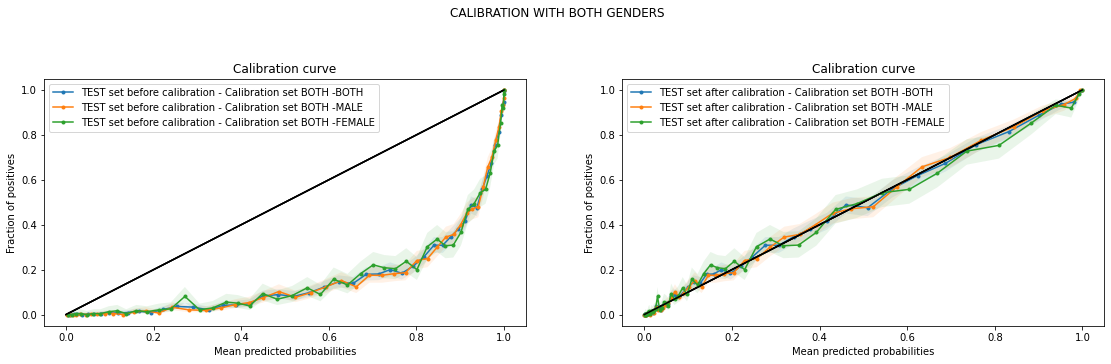

In [19]:
Path(f"output/tables/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/ece/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/mce/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/calibration_plots/{use_case}").mkdir(parents=True,exist_ok=True)

# Plot Calibration curves

image_counter = 0
plt.figure(figsize = (19,10))
data_to_calib = calibration_df_both.data_to_calib.unique()[0]
for calib_or_test in calibration_df_both['data_type'].unique():
    
    for before_after in calibration_df_both['before_after_calib'].unique():
        image_counter = image_counter + 1
        for gender in calibration_df_both['gender'].unique():
            data_2_plot=[]
            
            conditions = [ calibration_df_both['data_type']== calib_or_test,
                          calibration_df_both['before_after_calib']== before_after,
                          calibration_df_both['gender']==gender
                         ]

            data_2_plot = calibration_df_both[np.all(conditions,axis=0)].copy()
            if len(data_2_plot)>0:
                plt.subplot(2,2,image_counter)
                display_calibration_plot(data_2_plot['prob_true'], data_2_plot['prob_pred'],[data_2_plot['ci_l'],data_2_plot['ci_u']],calib_or_test,before_after,gender,data_to_calib)

plt.suptitle(f"CALIBRATION WITH BOTH GENDERS")
#plt.savefig(Path(f"output/calibration_plots/{use_case}/{model_num}.jpg"))


### Calibration using female

In [20]:
# APPLY PLATT SCALING

# FIT PLATT SCALING ON CALIBRATION DATA
platt_scaling = fit_platt_scaling(thr_female_pred)


## TRANSFORM
test_pred_fem = test_pred.copy()
test_pred_fem['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(test_pred_fem.PREDICTION))
test_pred_fem['data']='TEST'
test_pred_fem['DATA_TO_CALIBRATE']='FEMALE'
test_pred_fem['GENDER']= 'BOTH'

# TEST DATA - 2019
male_pred_df_fem = male_pred_df.copy()
male_pred_df_fem['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(male_pred_df_fem.PREDICTION))
male_pred_df_fem['data']='TEST'
male_pred_df_fem['DATA_TO_CALIBRATE']='FEMALE'
male_pred_df_fem['GENDER']= 'MALE'

# TEST DATA - 2020
female_pred_df_fem = female_pred_df.copy()
female_pred_df_fem['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(female_pred_df_fem.PREDICTION))
female_pred_df_fem['data']='TEST'
female_pred_df_fem['DATA_TO_CALIBRATE']='FEMALE'
female_pred_df_fem['GENDER']= 'FEMALE'


In [21]:
pdata_discharge_fem = pd.concat([test_pred_fem, male_pred_df_fem,female_pred_df_fem],axis=0,ignore_index=False)


In [22]:
bins = 50
strategy = 'quantile'
calibration_df_fem = pd.DataFrame()

for i_data in pdata_discharge_fem['data'].unique():
    data_to_calib = pdata_discharge_fem['DATA_TO_CALIBRATE'].iloc[0]
    gender_type = pdata_discharge_fem.loc[pdata_discharge_fem['data']==i_data,'GENDER'].unique()
    for gender in gender_type:
        print(i_data,gender)
        
        conditions = [ pdata_discharge_fem['data']==i_data , 
                      pdata_discharge_fem['GENDER']==gender,
                      pdata_discharge_fem['DATA_TO_CALIBRATE']== data_to_calib
                     ]
        df = pdata_discharge_fem[np.all(conditions,axis=0)].copy()
        
        prob_true, prob_pred, ci, ece,mce = calibration_plot(df.LABEL, df.PREDICTION,n_bins = bins, strategy = strategy)
        
        df_tmp = pd.DataFrame({"data_type":i_data ,
              "before_after_calib":"before",
              "data_to_calib": data_to_calib,                
              "gender":gender,
              "prob_true":prob_true,
             "prob_pred":prob_pred,
             "ci_l":ci[0],
             "ci_u":ci[1],
             "ece":ece,
             "mce":mce })
        calibration_df_fem = pd.concat([calibration_df_fem, df_tmp],axis=0, ignore_index=True)
        
        prob_true, prob_pred, ci, ece,mce = calibration_plot(df.LABEL, 
                                                         df.PREDICTION_AFTER_CALIB,
                                                         n_bins = bins, 
                                                         strategy = strategy)
        
        df_tmp = pd.DataFrame({"data_type":i_data ,
              "before_after_calib":"after",
              "data_to_calib": data_to_calib,                
              "gender":gender,
              "prob_true":prob_true,
             "prob_pred":prob_pred,
             "ci_l":ci[0],
             "ci_u":ci[1],
             "ece":ece,
             "mce":mce})
        
        calibration_df_fem = pd.concat([calibration_df_fem, df_tmp],axis=0, ignore_index=True)


TEST BOTH
TEST MALE
TEST FEMALE


In [23]:
calibration_df_fem

,data_type,before_after_calib,data_to_calib,gender,prob_true,prob_pred,ci_l,ci_u,ece,mce
0,TEST,before,FEMALE,BOTH,0.000000,0.003688,4.336809e-19,0.005743,0.29107,0.58277
1,TEST,before,FEMALE,BOTH,0.000000,0.010268,4.336809e-19,0.005752,0.29107,0.58277
2,TEST,before,FEMALE,BOTH,0.001506,0.017562,2.658997e-04,0.008481,0.29107,0.58277
3,TEST,before,FEMALE,BOTH,0.003012,0.026257,8.264013e-04,0.010915,0.29107,0.58277
4,TEST,before,FEMALE,BOTH,0.000000,0.037243,4.336809e-19,0.005752,0.29107,0.58277
...,...,...,...,...,...,...,...,...,...,...
295,TEST,after,FEMALE,FEMALE,0.851695,0.832434,8.007320e-01,0.891392,0.02502,0.08715
296,TEST,after,FEMALE,FEMALE,0.931915,0.905860,8.922762e-01,0.957660,0.02502,0.08715
297,TEST,after,FEMALE,FEMALE,0.919149,0.957002,8.771840e-01,0.947631,0.02502,0.08715
298,TEST,after,FEMALE,FEMALE,0.982979,0.986158,9.570599e-01,0.993361,0.02502,0.08715


Text(0.5, 0.98, 'CALIBRATION WITH FEMALE')

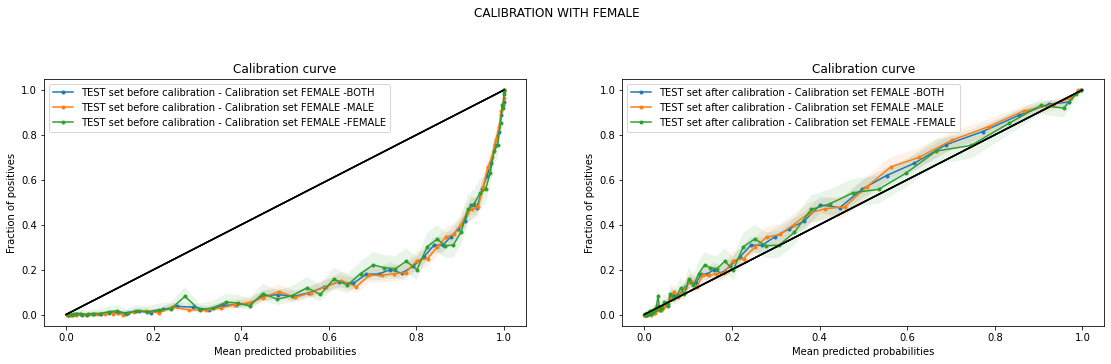

In [24]:
# Plot Calibration curves

image_counter = 0
plt.figure(figsize = (19,10))
data_to_calib = calibration_df_fem.data_to_calib.unique()[0]
for calib_or_test in calibration_df_fem['data_type'].unique():
    
    for before_after in calibration_df_fem['before_after_calib'].unique():
        image_counter = image_counter + 1
        for gender in calibration_df_fem['gender'].unique():
            data_2_plot=[]
            
            conditions = [ calibration_df_fem['data_type']== calib_or_test,
                          calibration_df_fem['before_after_calib']== before_after,
                          calibration_df_fem['gender']==gender
                         ]

            data_2_plot = calibration_df_fem[np.all(conditions,axis=0)].copy()
            if len(data_2_plot)>0:
                plt.subplot(2,2,image_counter)
                display_calibration_plot(data_2_plot['prob_true'], data_2_plot['prob_pred'],[data_2_plot['ci_l'],data_2_plot['ci_u']],calib_or_test,before_after,gender,data_to_calib )

plt.suptitle(f"CALIBRATION WITH FEMALE")
#plt.savefig(Path(f"output/calibration_plots/{use_case}/{model_num}.jpg"))

### Calibration using male 

In [25]:
# APPLY PLATT SCALING

# FIT PLATT SCALING ON CALIBRATION DATA
platt_scaling = fit_platt_scaling(thr_male_pred)

## TRANSFORM
test_pred_male = test_pred.copy()
test_pred_male['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(test_pred_male.PREDICTION))
test_pred_male['data']='TEST'
test_pred_male['DATA_TO_CALIBRATE']='MALE'
test_pred_male['GENDER']= 'BOTH'

# TEST DATA - 2019
male_pred_df_male = male_pred_df.copy()
male_pred_df_male['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(male_pred_df_male.PREDICTION))
male_pred_df_male['data']='TEST'
male_pred_df_male['DATA_TO_CALIBRATE']='MALE'
male_pred_df_male['GENDER']= 'MALE'

# TEST DATA - 2020
female_pred_df_male = female_pred_df.copy()
female_pred_df_male['PREDICTION_AFTER_CALIB'] = platt_scaling.transform(np.array(female_pred_df_male.PREDICTION))
female_pred_df_male['data']='TEST'
female_pred_df_male['DATA_TO_CALIBRATE']='MALE'
female_pred_df_male['GENDER']= 'FEMALE'


In [26]:
pdata_discharge_male = pd.concat([test_pred_male, male_pred_df_male,female_pred_df_male],axis=0,ignore_index=False)


In [27]:
bins = 50
strategy = 'quantile'
calibration_df_male = pd.DataFrame()

for i_data in pdata_discharge_male['data'].unique():
    data_to_calib = pdata_discharge_male['DATA_TO_CALIBRATE'].iloc[0]
    gender_type = pdata_discharge_male.loc[pdata_discharge_male['data']==i_data,'GENDER'].unique()
    for gender in gender_type:
        print(i_data,gender)
        
        conditions = [ pdata_discharge_male['data']==i_data , 
                      pdata_discharge_male['GENDER']==gender,
                      pdata_discharge_male['DATA_TO_CALIBRATE']== data_to_calib  
                     ]
        df = pdata_discharge_male[np.all(conditions,axis=0)].copy()
        
        prob_true, prob_pred, ci, ece,mce = calibration_plot(df.LABEL, df.PREDICTION,n_bins = bins, strategy = strategy)
        
        df_tmp = pd.DataFrame({"data_type":i_data ,
              "before_after_calib":"before",
              "data_to_calib": data_to_calib, 
              "gender":gender,
              "prob_true":prob_true,
             "prob_pred":prob_pred,
             "ci_l":ci[0],
             "ci_u":ci[1],
             "ece":ece,
             "mce":mce })
        calibration_df_male = pd.concat([calibration_df_male, df_tmp],axis=0, ignore_index=True)
        
        prob_true, prob_pred, ci, ece,mce = calibration_plot(df.LABEL, 
                                                         df.PREDICTION_AFTER_CALIB,
                                                         n_bins = bins, 
                                                         strategy = strategy)
        
        df_tmp = pd.DataFrame({"data_type":i_data ,
              "before_after_calib":"after",
              "data_to_calib": data_to_calib,                  
              "gender":gender,
              "prob_true":prob_true,
             "prob_pred":prob_pred,
             "ci_l":ci[0],
             "ci_u":ci[1],
             "ece":ece,
             "mce":mce})
        
        calibration_df_male = pd.concat([calibration_df_male, df_tmp],axis=0, ignore_index=True)


TEST BOTH
TEST MALE
TEST FEMALE


In [28]:
calibration_df = pd.concat([calibration_df_both, calibration_df_male,calibration_df_fem])
calibration_df

,data_type,before_after_calib,data_to_calib,gender,prob_true,prob_pred,ci_l,ci_u,ece,mce
0,TEST,before,BOTH,BOTH,0.000000,0.003688,4.336809e-19,0.005743,0.29107,0.58277
1,TEST,before,BOTH,BOTH,0.000000,0.010268,4.336809e-19,0.005752,0.29107,0.58277
2,TEST,before,BOTH,BOTH,0.001506,0.017562,2.658997e-04,0.008481,0.29107,0.58277
3,TEST,before,BOTH,BOTH,0.003012,0.026257,8.264013e-04,0.010915,0.29107,0.58277
4,TEST,before,BOTH,BOTH,0.000000,0.037243,4.336809e-19,0.005752,0.29107,0.58277
...,...,...,...,...,...,...,...,...,...,...
295,TEST,after,FEMALE,FEMALE,0.851695,0.832434,8.007320e-01,0.891392,0.02502,0.08715
296,TEST,after,FEMALE,FEMALE,0.931915,0.905860,8.922762e-01,0.957660,0.02502,0.08715
297,TEST,after,FEMALE,FEMALE,0.919149,0.957002,8.771840e-01,0.947631,0.02502,0.08715
298,TEST,after,FEMALE,FEMALE,0.982979,0.986158,9.570599e-01,0.993361,0.02502,0.08715


Text(0.5, 0.98, 'CALIBRATION WITH FEMALE')

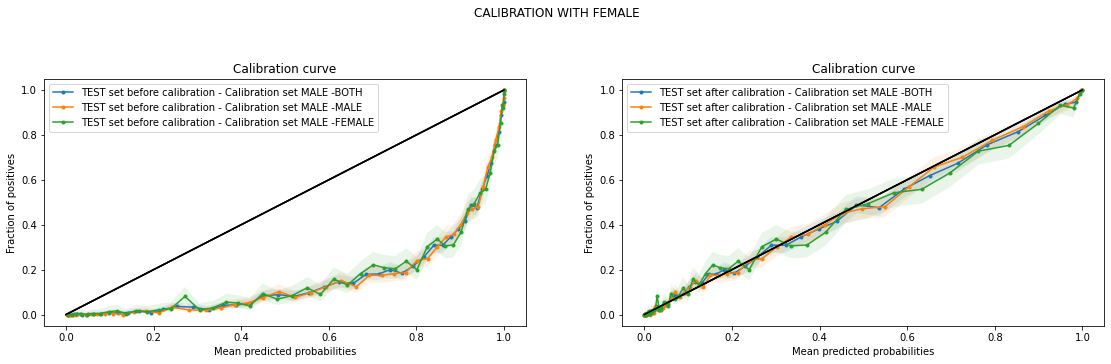

In [29]:
# Plot Calibration curves

image_counter = 0
plt.figure(figsize = (19,10))
data_to_calib = calibration_df_male.data_to_calib.unique()[0]
for calib_or_test in calibration_df_male['data_type'].unique():
    
    for before_after in calibration_df_male['before_after_calib'].unique():
        image_counter = image_counter + 1
        for gender in calibration_df_male['gender'].unique():
            data_2_plot=[]
            
            conditions = [ calibration_df_male['data_type']== calib_or_test,
                          calibration_df_male['before_after_calib']== before_after,
                          calibration_df_male['gender']==gender
                         ]

            data_2_plot = calibration_df_male[np.all(conditions,axis=0)].copy()
            if len(data_2_plot)>0:
                plt.subplot(2,2,image_counter)
                display_calibration_plot(data_2_plot['prob_true'], data_2_plot['prob_pred'],[data_2_plot['ci_l'],data_2_plot['ci_u']],calib_or_test,before_after,gender,data_to_calib )

plt.suptitle(f"CALIBRATION WITH FEMALE")
#plt.savefig(Path(f"output/calibration_plots/{use_case}/{model_num}.jpg"))

In [30]:
results_df = calibration_df.groupby(['data_type','before_after_calib','data_to_calib','gender'])['ece','mce'].max().reset_index()
results_df[results_df.gender == 'FEMALE']

,data_type,before_after_calib,data_to_calib,gender,ece,mce
1,TEST,after,BOTH,FEMALE,0.01988,0.07008
4,TEST,after,FEMALE,FEMALE,0.02502,0.08715
7,TEST,after,MALE,FEMALE,0.02294,0.07923
10,TEST,before,BOTH,FEMALE,0.29755,0.60104
13,TEST,before,FEMALE,FEMALE,0.29755,0.60104
16,TEST,before,MALE,FEMALE,0.29755,0.60104


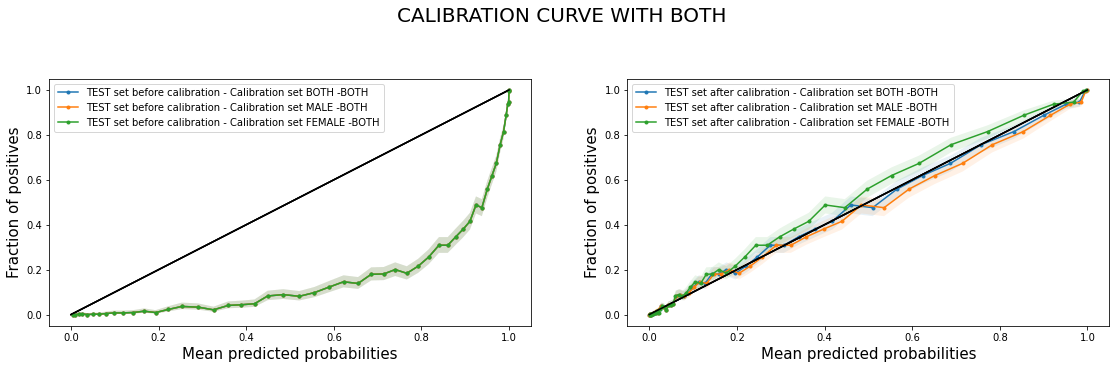

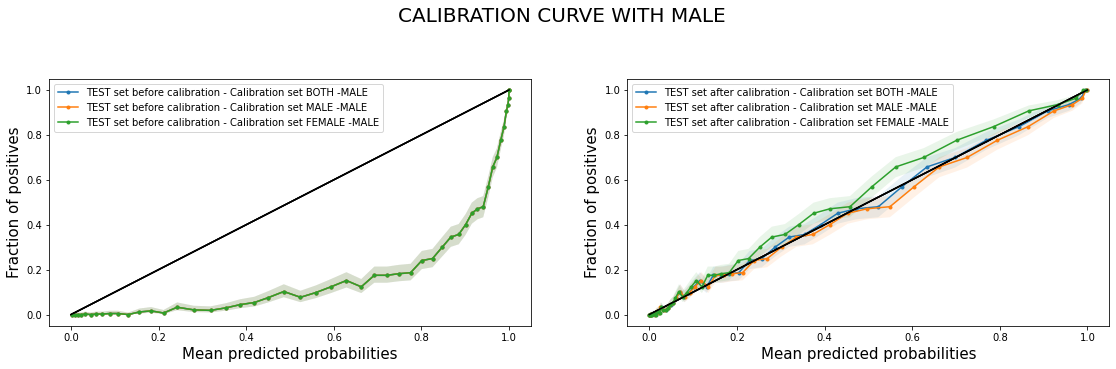

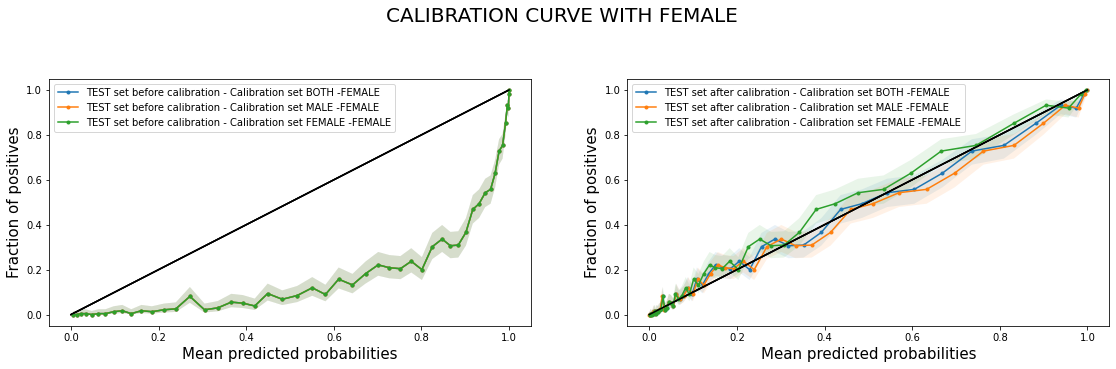

In [31]:
Path(f"output/tables/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/ece/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/mce/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/calibration_plots/{use_case}").mkdir(parents=True,exist_ok=True)

# Plot Calibration curves
for gender in calibration_df['gender'].unique():


    image_counter = 0
    plt.figure(figsize = (19,10))
    for calib_or_test in calibration_df['data_type'].unique():
        for before_after in calibration_df['before_after_calib'].unique():
            image_counter = image_counter + 1
            for data_to_calib in calibration_df['data_to_calib'].unique():
                data_2_plot=[]
                conditions = [ calibration_df['data_type']== calib_or_test,
                              calibration_df['before_after_calib']== before_after,
                              calibration_df['gender']==gender,
                              calibration_df['data_to_calib']==data_to_calib
                             ]

                data_2_plot = calibration_df[np.all(conditions,axis=0)].copy()
                if len(data_2_plot)>0:
                    plt.subplot(2,2,image_counter)
                    display_calibration_plot(data_2_plot['prob_true'], data_2_plot['prob_pred'],[data_2_plot['ci_l'],data_2_plot['ci_u']],calib_or_test,before_after,gender,data_to_calib)
                    plt.title('')
                    plt.xlabel("Mean predicted probabilities", size = 15)
                    plt.ylabel("Fraction of positives", size = 15)
    plt.suptitle(f"CALIBRATION CURVE WITH {gender}", size = 20)
    #plt.savefig(f'Calibration_curve_calibrated_with_{data_to_calib}')
    
#plt.savefig(Path(f"output/calibration_plots/{use_case}/{model_num}.jpg"))


In [32]:
def display_calibration_plot(prob_true, prob_pred,ci,calib_or_test,before_or_after,gender,calib_data):
    
    # fig, ax = plt.subplots()
    plt.plot(prob_pred,prob_true, marker='.', label = f'{calib_data}')
    # plt.plot([0,1], [0,1], color = 'black', label = 'Reference curve')
    plt.plot([0,1], [0,1], color = 'black')
    plt.fill_between(prob_pred, ci[0], ci[1], alpha=.1)
    # plt.fill_between(prob_pred, ci[0], ci[1], color='b', alpha=.1)
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("Fraction of positives")
    #plt.title('Calibration curve')
    plt.legend()

BOTH
[0.01057] [0.04264]
MALE
[0.0127] [0.06912]


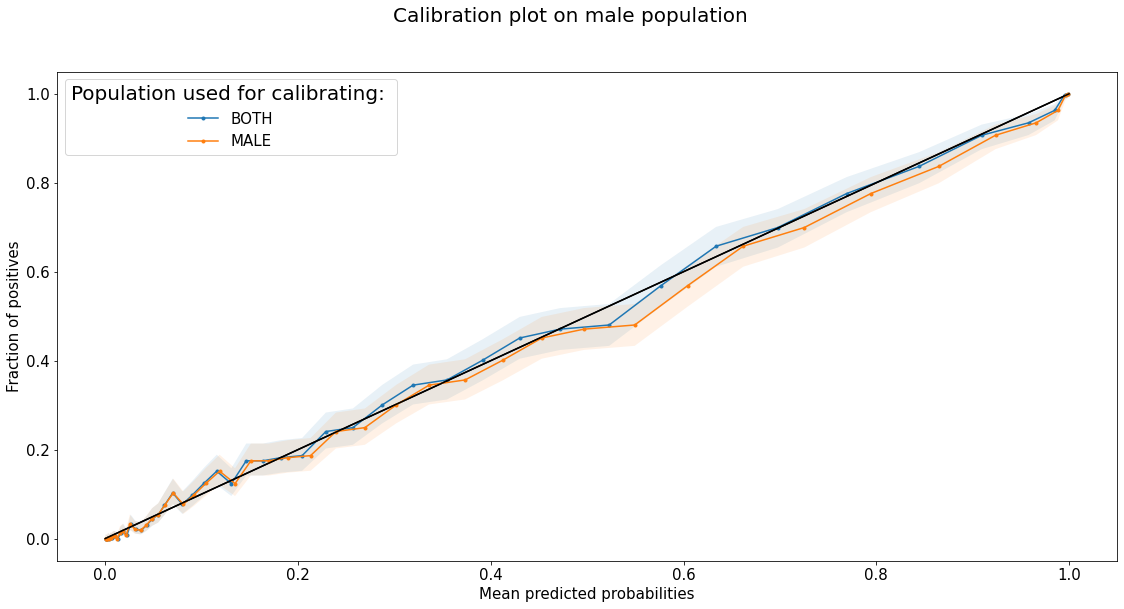

In [33]:
Path(f"output/tables/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/ece/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/mce/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/calibration_plots/{use_case}").mkdir(parents=True,exist_ok=True)

# Plot Calibration curves
plt.figure(figsize = (19,9))

for gender in calibration_df['gender'].unique()[1:-1]:
    calib_or_test = 'TEST'
    before_after = 'after'
    calibration_df1 = calibration_df[calibration_df['data_type'] == calib_or_test]
    calibration_df1 = calibration_df1[calibration_df1['before_after_calib'] == before_after]
    for data_to_calib in calibration_df1['data_to_calib'].unique()[:-1]:
        data_2_plot=[]
        conditions = [
                      calibration_df1['gender']==gender,
                      calibration_df1['data_to_calib']==data_to_calib
                     ]

        data_2_plot = calibration_df1[np.all(conditions,axis=0)].copy()
        print(data_to_calib)
        print(data_2_plot.ece.unique(), data_2_plot.mce.unique())
        if len(data_2_plot)>0:
            display_calibration_plot(data_2_plot['prob_true'], data_2_plot['prob_pred'],[data_2_plot['ci_l'],data_2_plot['ci_u']],calib_or_test,before_after,gender,data_to_calib)
            plt.xlabel("Mean predicted probabilities", size = 15)
            plt.ylabel("Fraction of positives", size = 15)
            plt.xticks(size = 15)
            plt.yticks(size = 15)
            legend = plt.legend(prop={'size': 15}, title = 'Population used for calibrating: ')
            legend.get_title().set_fontsize('20')
plt.suptitle(f"Calibration plot on male population", size = 20)
plt.savefig('calib_male_population')

 

BOTH
[0.01988] [0.07008]
FEMALE
[0.02502] [0.08715]


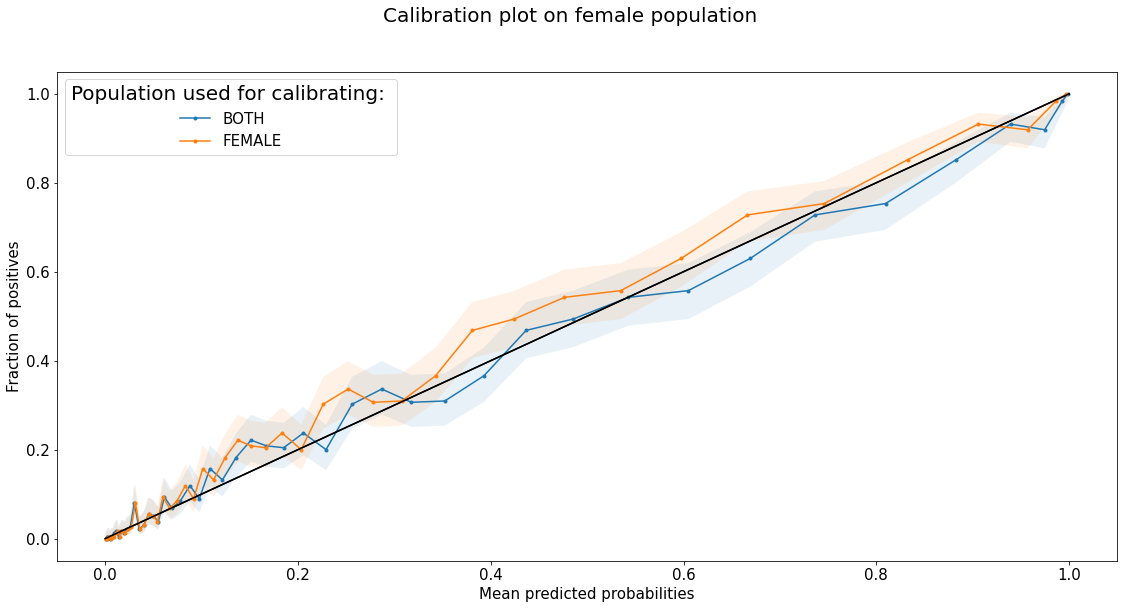

In [34]:
Path(f"output/tables/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/ece/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/mce/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/calibration_plots/{use_case}").mkdir(parents=True,exist_ok=True)

# Plot Calibration curves
plt.figure(figsize = (19,9))

for gender in calibration_df['gender'].unique()[2:]:
    calib_or_test = 'TEST'
    before_after = 'after'
    calibration_df1 = calibration_df[calibration_df['data_type'] == calib_or_test]
    calibration_df1 = calibration_df1[calibration_df1['before_after_calib'] == before_after]
    data_to_calib1 = calibration_df1['data_to_calib'].unique()
    for data_to_calib in [data_to_calib1[0],data_to_calib1[-1]]:
        data_2_plot=[]
        conditions = [
                      calibration_df1['gender']==gender,
                      calibration_df1['data_to_calib']==data_to_calib
                     ]

        data_2_plot = calibration_df1[np.all(conditions,axis=0)].copy()
        print(data_to_calib)
        print(data_2_plot.ece.unique(), data_2_plot.mce.unique())
        if len(data_2_plot)>0:
            display_calibration_plot(data_2_plot['prob_true'], data_2_plot['prob_pred'],[data_2_plot['ci_l'],data_2_plot['ci_u']],calib_or_test,before_after,gender,data_to_calib)
            plt.xlabel("Mean predicted probabilities", size = 15)
            plt.ylabel("Fraction of positives", size = 15)
            plt.xticks(size = 15)
            plt.yticks(size = 15)
            legend = plt.legend(prop={'size': 15}, title = 'Population used for calibrating: ')
            legend.get_title().set_fontsize('20')
plt.suptitle(f"Calibration plot on female population", size = 20)
plt.savefig('calib_female_population')


In [35]:
def display_calibration_plot(prob_true, prob_pred,ci,calib_or_test,before_or_after,gender,calib_data):
    
    # fig, ax = plt.subplots()
    plt.plot(prob_pred,prob_true, marker='.', label = f'{calib_data}-{gender}')
    # plt.plot([0,1], [0,1], color = 'black', label = 'Reference curve')
    plt.plot([0,1], [0,1], color = 'black')
    plt.fill_between(prob_pred, ci[0], ci[1], alpha=.1)
    # plt.fill_between(prob_pred, ci[0], ci[1], color='b', alpha=.1)
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("Fraction of positives")
    #plt.title('Calibration curve')
    plt.legend()

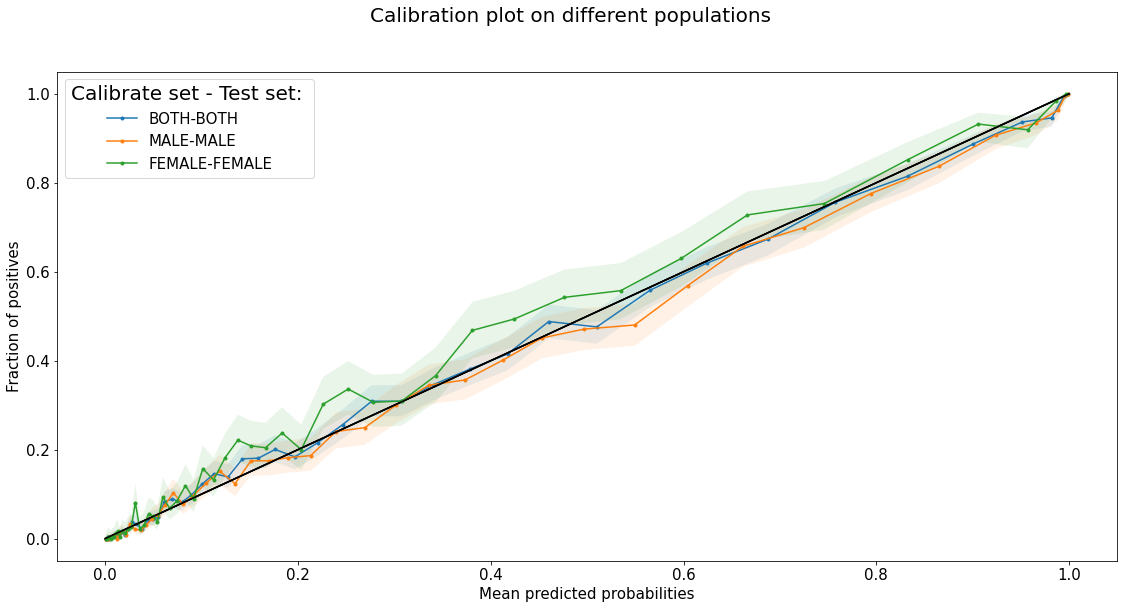

In [36]:
Path(f"output/tables/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/ece/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/mce/{use_case}").mkdir(parents=True,exist_ok=True)
Path(f"output/calibration_plots/{use_case}").mkdir(parents=True,exist_ok=True)

# Plot Calibration curves
plt.figure(figsize = (19,9))

for gender in calibration_df['gender'].unique():
    calib_or_test = 'TEST'
    before_after = 'after'
    calibration_df1 = calibration_df[calibration_df['data_type'] == calib_or_test]
    calibration_df1 = calibration_df1[calibration_df1['before_after_calib'] == before_after]
    for data_to_calib in calibration_df1['data_to_calib'].unique():
        if(data_to_calib == gender):
            data_2_plot=[]
            conditions = [
                          calibration_df1['gender']==gender,
                          calibration_df1['data_to_calib']==data_to_calib
                         ]

            data_2_plot = calibration_df1[np.all(conditions,axis=0)].copy()
            if len(data_2_plot)>0:
                display_calibration_plot(data_2_plot['prob_true'], data_2_plot['prob_pred'],[data_2_plot['ci_l'],data_2_plot['ci_u']],calib_or_test,before_after,gender,data_to_calib)
                plt.xlabel("Mean predicted probabilities", size = 15)
                plt.ylabel("Fraction of positives", size = 15)
                plt.xticks(size = 15)
                plt.yticks(size = 15)
                legend = plt.legend(prop={'size': 15}, title = 'Calibrate set - Test set: ')
                legend.get_title().set_fontsize('20')
    plt.suptitle(f"Calibration plot on different populations", size = 20)
    
plt.savefig('Calib_diff_population')


In [37]:
from mltools import UseCase
from mltools.settings import settings
import logging

from calibration.use_cases import configs

uc_config = configs.get_use_case('aki_kdigo_onset')

In [38]:
from mltools.training.thresholding import ThresholdDefiner

# Get the threshold set
dept_df = pdm.reader().read('departments')
'''thr_tl = dm.reader().read(f'{use_case}_thr_tl')

observations, labels, caseids = get_observations_from_tl(thr_tl)
y_pred = model.predict(observations)

thr_tl = pd.DataFrame(
    zip(caseids, labels, y_pred),
    columns=['CASEID', 'LABEL', 'PREDICTION'])'''

td = ThresholdDefiner.from_config(uc_config.thresholds)
td.compute_thresholds(thr_pred.LABEL, thr_pred_both.PREDICTION)
thr_dict = td.to_dict()
logging.info(
    f"Global threshold: {thr_dict['specific']:.2%}")
model.set_thresholds(thr_dict)

# Set department-specific thresholds
thr_tl_dept = thr_pred_both.merge(dept_df, on=['CASEID'], how='left')
groups = thr_tl_dept.groupby('DEPARTMENT')
thr_dept = {}
for dept in thr_tl_dept.DEPARTMENT.unique():
    group_df = groups.get_group(dept)
    td.compute_thresholds(group_df.LABEL, group_df.PREDICTION)
    thr_dept[dept] = {
        'thresholds': td.to_dict(),
        'sample_size': len(group_df),
        'incidence': group_df.LABEL.sum() / len(group_df)
    }
    logging.info(
        f"Threshold department {dept}: {float(thr_dept[dept]['thresholds']['specific']):.2%}")
model.set_thresholds_dept(thr_dept)

Global threshold: 7.60%
Threshold department 2100: 45.08%
Threshold department 2136: 45.08%
Threshold department 1100: 55.97%
Threshold department 0103: 14.73%
Threshold department 0153: 31.71%


In [39]:
thresholds_before_calib = model.thresholds

In [40]:
from mltools.training.thresholding import ThresholdDefiner

# Get the threshold set
dept_df = pdm.reader().read('departments')
'''thr_tl = dm.reader().read(f'{use_case}_thr_tl')

observations, labels, caseids = get_observations_from_tl(thr_tl)
y_pred = model.predict(observations)

thr_tl = pd.DataFrame(
    zip(caseids, labels, y_pred),
    columns=['CASEID', 'LABEL', 'PREDICTION'])'''

td = ThresholdDefiner.from_config(uc_config.thresholds)
td.compute_thresholds(thr_pred.LABEL, thr_pred_both.PREDICTION_AFTER_CALIB)
thr_dict = td.to_dict()
logging.info(
    f"Global threshold: {thr_dict['specific']:.2%}")
model.set_thresholds(thr_dict)

# Set department-specific thresholds
thr_tl_dept = thr_pred_both.merge(dept_df, on=['CASEID'], how='left')
groups = thr_tl_dept.groupby('DEPARTMENT')
thr_dept = {}
for dept in thr_tl_dept.DEPARTMENT.unique():
    group_df = groups.get_group(dept)
    td.compute_thresholds(group_df.LABEL, group_df.PREDICTION_AFTER_CALIB)
    thr_dept[dept] = {
        'thresholds': td.to_dict(),
        'sample_size': len(group_df),
        'incidence': group_df.LABEL.sum() / len(group_df)
    }
    logging.info(
        f"Threshold department {dept}: {float(thr_dept[dept]['thresholds']['specific']):.2%}")
model.set_thresholds_dept(thr_dept)

Global threshold: 0.74%
Threshold department 2100: 6.18%
Threshold department 2136: 6.18%
Threshold department 1100: 9.06%
Threshold department 0103: 1.48%
Threshold department 0153: 3.69%


In [41]:
thresholds_after_calib = model.thresholds

In [42]:
thresholds_after_calib

{'medium': 0.5,
 'high': 0.75,
 'sens90': 0.13360098014957147,
 'spec95': 0.4639576506125965,
 'spec90': 0.3131670000555229,
 'ppv10': 0.007387708312119441,
 'ppv25': 0.007387708312119441,
 'specific': 0.007387708312119441,
 'specific_high': 0.026169105678708532}

In [43]:
thresholds_before_calib

{'medium': 0.5,
 'high': 0.75,
 'sens90': 0.6684953570365906,
 'spec95': 0.925701916217804,
 'spec90': 0.863640308380127,
 'ppv10': 0.07597435265779495,
 'ppv25': 0.07597435265779495,
 'specific': 0.07597435265779495,
 'specific_high': 0.2417655736207962}

## Event Distribution per Gender

In [44]:
### ABSOLUTE FREQUENCY

absolute_frequency = pd.concat([
    male_pred_df.LABEL.value_counts(),
    female_pred_df.LABEL.value_counts()
], axis=1, keys=["MALE", "FEMALE"])

### RELATIVE FREQUENCY

relative_frequency = pd.concat([
    male_pred_df.LABEL.value_counts()/male_pred_df.shape[0],
    female_pred_df.LABEL.value_counts()/female_pred_df.shape[0]
], axis=1, keys=["MALE", "FEMALE"])

In [45]:
absolute_frequency

,MALE,FEMALE
0,15715,8732
1,5728,3030


In [46]:
g, p, dof, expected = chi2_contingency(np.array(absolute_frequency))#, lambda_="log-likelihood")

In [47]:
if p < STATISTICAL_SIGNIFICANCE:
    print("Null hypothesis REJECTED: There is a difference in the EVENT OCCURRENCE between GENDER")
else:
    print("Null hypothesis ACCEPTED: There is NO significant difference in the EVENT OCURRENCE between GENDER")

Null hypothesis ACCEPTED: There is NO significant difference in the EVENT OCURRENCE between GENDER


In [48]:
STATISTICAL_SIGNIFICANCE

0.05

In [49]:
relative_frequency

,MALE,FEMALE
0,0.732873,0.742391
1,0.267127,0.257609


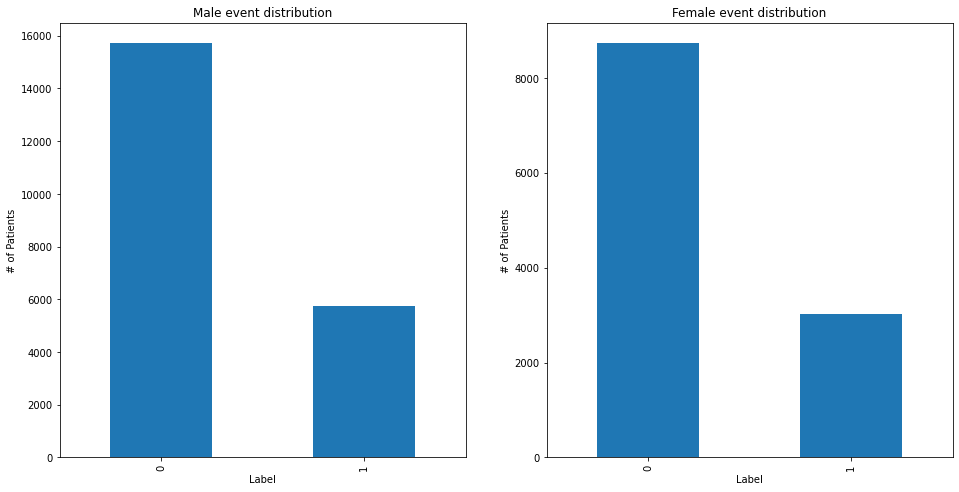

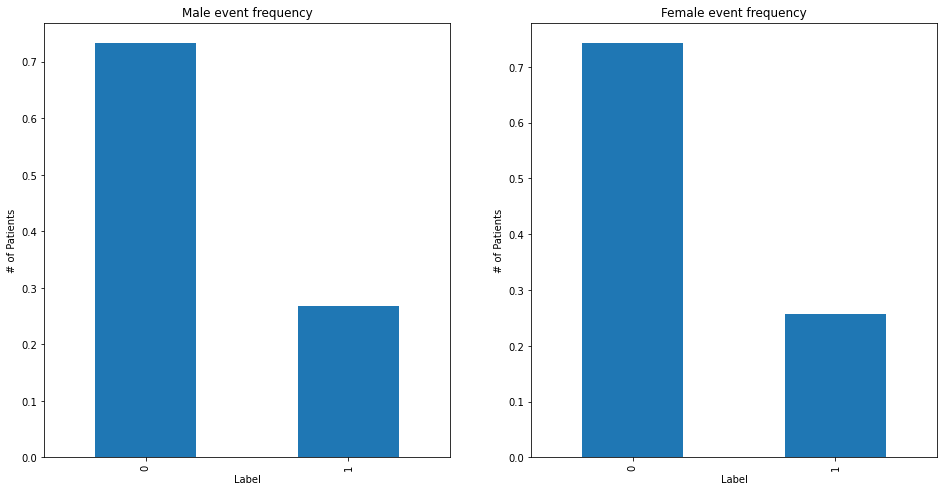

In [50]:
### ABSOLUTE FREQUENCY

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
male_pred_df.LABEL.value_counts().sort_index(ascending=True).plot(kind='bar', ax=axes[0])

axes[0].set_xlabel('Label')
axes[0].set_ylabel('# of Patients')
axes[0].set_title('Male event distribution')

female_pred_df.LABEL.value_counts().sort_index(ascending=True).plot(kind='bar', ax=axes[1])

axes[1].set_xlabel('Label')
axes[1].set_ylabel('# of Patients')
axes[1].set_title('Female event distribution')

### RELATIVE FREQUENCY

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
(male_pred_df.LABEL.value_counts()/male_pred_df.shape[0]).sort_index(ascending=True).plot(kind='bar', ax=axes[0])

axes[0].set_xlabel('Label')
axes[0].set_ylabel('# of Patients')
axes[0].set_title('Male event frequency')

(female_pred_df.LABEL.value_counts()/female_pred_df.shape[0]).sort_index(ascending=True).plot(kind='bar', ax=axes[1])

axes[1].set_xlabel('Label')
axes[1].set_ylabel('# of Patients')
axes[1].set_title('Female event frequency')
plt.savefig('gender_distribution')


## Prediction Distribution per Gender

In [51]:
model.thresholds

{'medium': 0.5,
 'high': 0.75,
 'sens90': 0.13360098014957147,
 'spec95': 0.4639576506125965,
 'spec90': 0.3131670000555229,
 'ppv10': 0.007387708312119441,
 'ppv25': 0.007387708312119441,
 'specific': 0.007387708312119441,
 'specific_high': 0.026169105678708532}

In [52]:
# Output: D statistic and a p-value corresponding to the D statistic.
# The D statistic is the absolute max distance between the CDFs of the two samples. 
# The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution. 
# You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.
kstest(male_pred_df_both.PREDICTION_AFTER_CALIB, female_pred_df_both.PREDICTION_AFTER_CALIB)

KstestResult(statistic=0.030472078064500557, pvalue=1.461325194569711e-06)

In [53]:
ks_2samp(male_pred_df.PREDICTION, female_pred_df.PREDICTION)

KstestResult(statistic=0.030472078064500557, pvalue=1.461325194569711e-06)

In [54]:
N_QUANTILES=20
quantile_male = np.quantile( male_pred_df_both.PREDICTION.values, [x/N_QUANTILES for x in range(0,N_QUANTILES+1)])
quantile_female = np.quantile( female_pred_df_both.PREDICTION.values, [x/N_QUANTILES for x in range(0,N_QUANTILES+1)])
quantile_male_after = np.quantile( male_pred_df_both.PREDICTION_AFTER_CALIB.values, [x/N_QUANTILES for x in range(0,N_QUANTILES+1)]).round(6)
quantile_female_after = np.quantile( female_pred_df_both.PREDICTION_AFTER_CALIB.values, [x/N_QUANTILES for x in range(0,N_QUANTILES+1)]).round(6)

In [55]:
pd.concat({'MALE_BEFORE': pd.Series(quantile_male), 'FEMALE_BEFORE': pd.Series(quantile_female),'MALE_AFTER': pd.Series(quantile_male_after), 'FEMALE_AFTER': pd.Series(quantile_female_after)}, axis=1)

,MALE_BEFORE,FEMALE_BEFORE,MALE_AFTER,FEMALE_AFTER
0,0.000003,0.000023,0.000000,0.000003
1,0.015494,0.022162,0.001552,0.002191
2,0.038750,0.054813,0.003775,0.005318
3,0.071544,0.097808,0.006950,0.009579
4,0.118471,0.148516,0.011715,0.014948
5,0.183019,0.212419,0.018872,0.022418
6,0.260737,0.289396,0.028718,0.032772
7,0.354892,0.366341,0.043108,0.045090
8,0.432979,0.434110,0.057900,0.058139
9,0.523504,0.515604,0.079822,0.077647


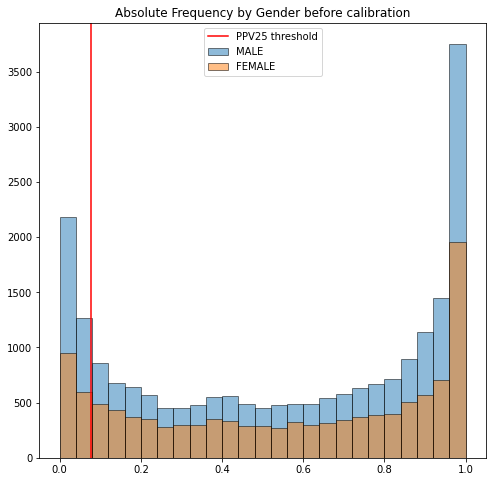

In [56]:
# male_pred_df.PREDICTION
plt.figure(figsize=(8, 8))
plt.hist(male_pred_df_both.PREDICTION, bins=25, ec='black', alpha = 0.5, label="MALE")
plt.hist(female_pred_df_both.PREDICTION, bins=25, ec='black', alpha = 0.5, label="FEMALE")
plt.axvline(x = thresholds_before_calib['ppv25'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold')
plt.legend()
plt.title('Absolute Frequency by Gender before calibration')
plt.savefig('abs_freq_gender_before_calib')

# title ABSOLUTE FREQUENCY

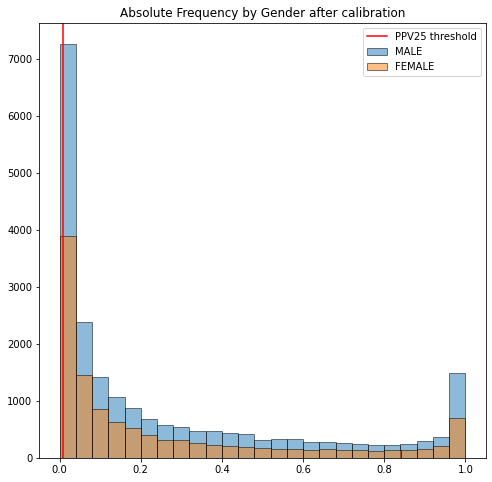

In [57]:
# male_pred_df.PREDICTION
plt.figure(figsize=(8, 8))
plt.hist(male_pred_df_both.PREDICTION_AFTER_CALIB, bins=25, ec='black', alpha = 0.5, label="MALE")
plt.hist(female_pred_df_both.PREDICTION_AFTER_CALIB, bins=25, ec='black', alpha = 0.5, label="FEMALE")
plt.axvline(x = thresholds_after_calib['ppv25'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold')
plt.legend()
plt.title('Absolute Frequency by Gender after calibration')
plt.savefig('abs_freq_gender_after_calib')

# title ABSOLUTE FREQUENCY

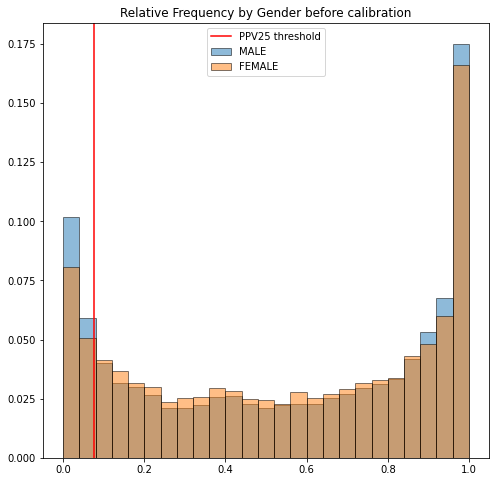

In [58]:
# male_pred_df.PREDICTION
plt.figure(figsize=(8, 8))
plt.hist(male_pred_df_both.PREDICTION, bins=25, ec='black', alpha = 0.5, label="MALE", weights=np.ones_like(male_pred_df_both.PREDICTION) / len(male_pred_df_both.PREDICTION))
plt.hist(female_pred_df_both.PREDICTION, bins=25, ec='black', alpha = 0.5, label="FEMALE", weights=np.ones_like(female_pred_df_both.PREDICTION) / len(female_pred_df_both.PREDICTION))
plt.axvline(x = thresholds_before_calib['ppv25'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold')
plt.legend()
plt.title('Relative Frequency by Gender before calibration')
plt.savefig('rel_freq_gender_before_calib')

# title RELATIVE FREQUENCY

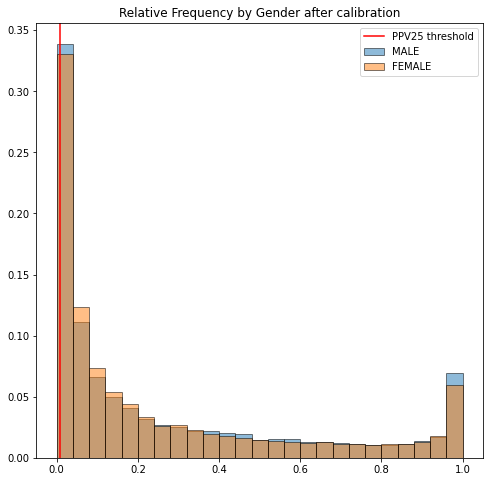

In [59]:
# male_pred_df.PREDICTION
plt.figure(figsize=(8, 8))
plt.hist(male_pred_df_both.PREDICTION_AFTER_CALIB, bins=25, ec='black', alpha = 0.5, label="MALE", weights=np.ones_like(male_pred_df_both.PREDICTION_AFTER_CALIB) / len(male_pred_df_both.PREDICTION_AFTER_CALIB))
plt.hist(female_pred_df_both.PREDICTION_AFTER_CALIB, bins=25, ec='black', alpha = 0.5, label="FEMALE", weights=np.ones_like(female_pred_df_both.PREDICTION_AFTER_CALIB) / len(female_pred_df_both.PREDICTION_AFTER_CALIB))
plt.axvline(x = thresholds_after_calib['ppv25'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold')
plt.legend()
plt.title('Relative Frequency by Gender after calibration')
plt.savefig('rel_freq_gender_after_calib')
# title RELATIVE FREQUENCY

In [60]:
# plt.barh(male_pred_df.LABEL.value_counts(), align='center', alpha=0.5)
# plt.yticks(y_pos, objects)
# plt.xlabel('')
# plt.title('')

# Model Metrics

In [61]:
def cm_to_values(cm):
    tn, fp, fn, tp  = cm.ravel()
    ret = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    return ret

def get_overdiagnosis(fp, tn):
    """
    False Positive Rate / Probability of False alarm / Fall-out
    - With underdiagnosis, can help us understand which
    subgroups are discriminated against by our classifier
    """
    return fp/(fp+tn)

def get_underdiagnosis(fn, tp):
    """
    False Negative Rate / Miss rate
    - With overdiagnosis, can help us understand which
    subgroups are discriminated against by our classifier
    """
    return fn/(fn+tp)

def get_true_positive_rate(tp, fn):
    """
    True Positive Rate
    """
    return tp/(tp+fn)
    
def get_false_positive_rate(fp, tn):
    """
    False Positive Rate
    """
    return fp/(tn+fp)

def get_equalized_odds_ratio(a_tpr, a_fpr, b_tpr, b_fpr):
    """
    Smaller between recall ratio and false positive ratio.
    Ratio of the smallest and largest group-level recalls and 
    FPRs across all groups.
    Unbiased model -> 1
    """
    min_tpr = min(a_tpr, b_tpr)
    max_tpr = max(a_tpr, b_tpr)
    
    min_fpr = min(a_fpr, b_fpr)
    max_fpr = max(a_fpr, b_fpr)
    
    tpr_ratio = min_tpr/max_tpr
    fpr_ratio = min_fpr/max_fpr
    
    return min(tpr_ratio, fpr_ratio)

def get_demographic_parity_ratio(a_tp, a_fp, a_n, b_tp, b_fp, b_n):
    """    
    Ratio of the smallest and the largest group-level selection
    rate across the grouping variable
    High ->  Patients of all groups are more likely to have equal
    probability of being assigned to the positive predicted class
    Unbiased model -> 1
    """
    group_a_parity = (a_tp + a_fp)/a_n
    group_b_parity = (b_tp + b_fp)/b_n
    
    min_group = min(group_a_parity, group_b_parity)
    max_group = max(group_a_parity, group_b_parity)
    
    return min_group/max_group

In [62]:
def get_bias_analisys_results(male_pred_df, female_pred_df, current_threshold, before_after):
    all_pred_df = pd.concat([male_pred_df, female_pred_df])
    male_cm = confusion_matrix(male_pred_df.LABEL, male_pred_df[before_after] > current_threshold)
    female_cm = confusion_matrix(female_pred_df.LABEL, female_pred_df[before_after] > current_threshold)
    all_cm  = confusion_matrix(all_pred_df.LABEL, all_pred_df[before_after] > current_threshold)
    
    male_cm_values = cm_to_values(male_cm)
    female_cm_values = cm_to_values(female_cm)
    all_cm_values = cm_to_values(all_cm)
    
    male_underdiagnosis = get_underdiagnosis(male_cm_values['fn'], male_cm_values['tp'])
    male_overdiagnosis = get_overdiagnosis(male_cm_values['fp'], male_cm_values['tn'])
    male_tpr = get_true_positive_rate(male_cm_values['tp'], male_cm_values['fn'])
    male_fpr = get_false_positive_rate(male_cm_values['fp'], male_cm_values['tn'])

    female_underdiagnosis = get_underdiagnosis(female_cm_values['fn'], female_cm_values['tp'])
    female_overdiagnosis = get_overdiagnosis(female_cm_values['fp'], female_cm_values['tn'])
    female_tpr = get_true_positive_rate(female_cm_values['tp'], female_cm_values['fn'])
    female_fpr = get_false_positive_rate(female_cm_values['fp'], female_cm_values['tn'])

    all_underdiagnosis = get_underdiagnosis(all_cm_values['fn'], all_cm_values['tp'])
    all_overdiagnosis = get_overdiagnosis(all_cm_values['fp'], all_cm_values['tn'])
    equalized_odds_ratio = get_equalized_odds_ratio(male_tpr, male_fpr, female_tpr, female_fpr)
    demographic_parity_ratio = get_demographic_parity_ratio(
        male_cm_values['tp'], male_cm_values['fp'], male_pred_df.shape[0],
        female_cm_values['tp'], female_cm_values['fp'], female_pred_df.shape[0]
    )

    bias_dict = {
        'ALL_UNDERDIAGNOSIS': all_underdiagnosis,
        'MALE_UNDERDIAGNOSIS': male_underdiagnosis,
        'FEMALE_UNDERDIAGNOSIS': female_underdiagnosis,
        'MALE_UNDERDIAGNOSIS_DIFF': all_underdiagnosis - male_underdiagnosis,
        'FEMALE_UNDERDIAGNOSIS_DIFF': all_underdiagnosis - female_underdiagnosis,

        'ALL_OVERDIAGNOSIS': all_overdiagnosis,
        'MALE_OVERDIAGNOSIS': male_overdiagnosis,
        'FEMALE_OVERDIAGNOSIS': female_overdiagnosis,
        'MALE_OVERDIAGNOSIS_DIFF': all_overdiagnosis - male_overdiagnosis,
        'FEMALE_OVERDIAGNOSIS_DIFF': all_overdiagnosis - female_overdiagnosis,

        'EQUALIZED_ODDS_RATIO': equalized_odds_ratio,
        'DEMOGRAPHIC_PARITY_RATIO': demographic_parity_ratio,
    }

    current_bias_results = pd.DataFrame([bias_dict]).T
    
    return current_bias_results

In [63]:
current_threshold = model.thresholds['sens90']
current_threshold = model.thresholds['ppv25']

In [64]:
 model.thresholds

{'medium': 0.5,
 'high': 0.75,
 'sens90': 0.13360098014957147,
 'spec95': 0.4639576506125965,
 'spec90': 0.3131670000555229,
 'ppv10': 0.007387708312119441,
 'ppv25': 0.007387708312119441,
 'specific': 0.007387708312119441,
 'specific_high': 0.026169105678708532}

In [65]:
l_bias_analysis_results_before_both = []

for threshold_name, threshold in model.thresholds.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df, female_pred_df, threshold, 'PREDICTION')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_before_both.append(current_bias_analysis_result)
    
bias_results_before_df_both = pd.concat(l_bias_analysis_results_before_both, axis=1)
bias_results_before_df_both

,medium,high,sens90,spec95,spec90,ppv10,ppv25,specific,specific_high
ALL_UNDERDIAGNOSIS,0.035510,0.120918,0.002169,0.029116,0.011532,0.000000,0.000000,0.000000,0.000114
MALE_UNDERDIAGNOSIS,0.030726,0.109288,0.001222,0.024092,0.008205,0.000000,0.000000,0.000000,0.000000
FEMALE_UNDERDIAGNOSIS,0.044554,0.142904,0.003960,0.038614,0.017822,0.000000,0.000000,0.000000,0.000330
MALE_UNDERDIAGNOSIS_DIFF,0.004784,0.011630,0.000947,0.005024,0.003327,0.000000,0.000000,0.000000,0.000114
FEMALE_UNDERDIAGNOSIS_DIFF,-0.009044,-0.021986,-0.001791,-0.009498,-0.006289,0.000000,0.000000,0.000000,-0.000216
ALL_OVERDIAGNOSIS,0.416984,0.231644,0.724220,0.441404,0.565632,0.970385,0.970385,0.970385,0.905060
MALE_OVERDIAGNOSIS,0.414508,0.232644,0.709768,0.437862,0.557047,0.964302,0.964302,0.964302,0.895196
FEMALE_OVERDIAGNOSIS,0.421438,0.229844,0.750229,0.447778,0.581081,0.981333,0.981333,0.981333,0.922813
MALE_OVERDIAGNOSIS_DIFF,0.002475,-0.001000,0.014452,0.003542,0.008584,0.006083,0.006083,0.006083,0.009864
FEMALE_OVERDIAGNOSIS_DIFF,-0.004455,0.001800,-0.026009,-0.006374,-0.015449,-0.010948,-0.010948,-0.010948,-0.017753


In [66]:
l_bias_analysis_results_after_both = []

for threshold_name, threshold in thresholds_after_calib.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df_both, female_pred_df_both, threshold, 'PREDICTION_AFTER_CALIB')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_after_both.append(current_bias_analysis_result)
    

bias_results_after_df_both = pd.concat(l_bias_analysis_results_after_both, axis=1)
bias_results_after_df_both    

,medium,high,sens90,spec95,spec90,ppv10,ppv25,specific,specific_high
ALL_UNDERDIAGNOSIS,0.354761,0.542019,0.079813,0.328271,0.211464,0.000685,0.000685,0.000685,0.006508
MALE_UNDERDIAGNOSIS,0.342353,0.532297,0.072800,0.315119,0.194483,0.000524,0.000524,0.000524,0.005237
FEMALE_UNDERDIAGNOSIS,0.378218,0.560396,0.093069,0.353135,0.243564,0.000990,0.000990,0.000990,0.008911
MALE_UNDERDIAGNOSIS_DIFF,0.012408,0.009721,0.007012,0.013153,0.016981,0.000161,0.000161,0.000161,0.001271
FEMALE_UNDERDIAGNOSIS_DIFF,-0.023456,-0.018377,-0.013257,-0.024864,-0.032101,-0.000305,-0.000305,-0.000305,-0.002403
ALL_OVERDIAGNOSIS,0.058944,0.015257,0.297010,0.069047,0.133922,0.802593,0.802593,0.802593,0.617008
MALE_OVERDIAGNOSIS,0.058288,0.014318,0.297677,0.069042,0.135221,0.787973,0.787973,0.787973,0.606172
FEMALE_OVERDIAGNOSIS,0.060124,0.016949,0.295809,0.069056,0.131585,0.828905,0.828905,0.828905,0.636509
MALE_OVERDIAGNOSIS_DIFF,0.000656,0.000940,-0.000668,0.000005,-0.001299,0.014620,0.014620,0.014620,0.010836
FEMALE_OVERDIAGNOSIS_DIFF,-0.001180,-0.001692,0.001201,-0.000009,0.002337,-0.026312,-0.026312,-0.026312,-0.019501


In [67]:
N_QUANTILES = 40
thresholds = np.quantile(test_pred_both.PREDICTION.values, [x/N_QUANTILES for x in range(0,N_QUANTILES+1)]).round(3)

In [68]:
threshold_dict = dict(zip(thresholds.astype(str), thresholds))

In [69]:
test_pred_both

,CASEID,LABEL,PREDICTION,OBS,PREDICTION_AFTER_CALIB,data,DATA_TO_CALIBRATE,GENDER
0,1364742,0,0.360764,GENDER-MALE AGE_GROUP-6 MEMO_ICD-N19 MEMO_ICD-...,0.044117,TEST,BOTH,BOTH
1,1369052,1,0.780920,GENDER-MALE AGE_GROUP-7 MEMO_ICD-J90 MEMO_ICD-...,0.209181,TEST,BOTH,BOTH
2,1384756,0,0.659102,MEMO_ICD-I63.9 GENDER-FEMALE AGE_GROUP-4 MEMO_...,0.129053,TEST,BOTH,BOTH
3,1391124,0,0.073599,MEMO_ICD-I63.9 MEMO_ICD-I34.0 LAB_RESULT-ERYTH...,0.007153,TEST,BOTH,BOTH
4,1392168,0,0.848883,GENDER-MALE AGE_GROUP-6 MEMO_ICD-R53 MEMO_ICD-...,0.289251,TEST,BOTH,BOTH
...,...,...,...,...,...,...,...,...
33200,1906019,0,0.876697,GENDER-MALE AGE_GROUP-7 MEMO_ICD-L98.9 LAB_RES...,0.337201,TEST,BOTH,BOTH
33201,1906136,0,0.648442,GENDER-MALE AGE_GROUP-5 MEMO_ICD-I25.14 MEMO_I...,0.124120,TEST,BOTH,BOTH
33202,1906175,1,0.356635,GENDER-MALE AGE_GROUP-7 ICD_HISTORICAL-I50.13 ...,0.043406,TEST,BOTH,BOTH
33203,1906177,0,0.236954,GENDER-MALE AGE_GROUP-5 LAB_RESULT-ERYTHROCYTE...,0.025539,TEST,BOTH,BOTH


In [70]:
l_bias_analysis_results_before_both = []

for threshold_name, threshold in threshold_dict.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df_both, female_pred_df_both, threshold, 'PREDICTION')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_before_both.append(current_bias_analysis_result)
    
bias_results_before_df_both = pd.concat(l_bias_analysis_results_before_both, axis=1)
bias_results_before_df_both['DATA_TO_CALIBRATE'] = 'BOTH'
bias_results_before_df_both['CALIBRATION_STEP'] = 'BEFORE'
bias_results_before_df_both

,0.0,0.009,0.017,0.029,0.044,0.06,0.08,0.103,0.129,0.161,...,0.944,0.959,0.971,0.982,0.991,0.996,0.999,1.0,DATA_TO_CALIBRATE,CALIBRATION_STEP
ALL_UNDERDIAGNOSIS,0.0,0.000000,0.000000,0.000228,0.000343,0.000571,0.000799,0.001256,0.002055,0.002855,...,0.378054,0.434117,0.494976,0.565083,0.641927,0.717059,0.808975,1.0,BOTH,BEFORE
MALE_UNDERDIAGNOSIS,0.0,0.000000,0.000000,0.000175,0.000175,0.000349,0.000524,0.000873,0.001222,0.001920,...,0.364525,0.423708,0.486557,0.555691,0.633554,0.708101,0.798359,1.0,BOTH,BEFORE
FEMALE_UNDERDIAGNOSIS,0.0,0.000000,0.000000,0.000330,0.000660,0.000990,0.001320,0.001980,0.003630,0.004620,...,0.403630,0.453795,0.510891,0.582838,0.657756,0.733993,0.829043,1.0,BOTH,BEFORE
MALE_UNDERDIAGNOSIS_DIFF,0.0,0.000000,0.000000,0.000054,0.000168,0.000222,0.000276,0.000383,0.000833,0.000934,...,0.013529,0.010409,0.008419,0.009392,0.008373,0.008958,0.010616,0.0,BOTH,BEFORE
FEMALE_UNDERDIAGNOSIS_DIFF,0.0,0.000000,0.000000,-0.000102,-0.000318,-0.000419,-0.000521,-0.000724,-0.001575,-0.001766,...,-0.025576,-0.019678,-0.015915,-0.017755,-0.015828,-0.016935,-0.020068,0.0,BOTH,BEFORE
ALL_OVERDIAGNOSIS,1.0,0.963758,0.933611,0.897124,0.863092,0.831431,0.795967,0.762875,0.729578,0.695259,...,0.049986,0.033869,0.021966,0.012476,0.006095,0.002986,0.000695,0.0,BOTH,BEFORE
MALE_OVERDIAGNOSIS,1.0,0.957366,0.925294,0.886223,0.850970,0.816799,0.780655,0.747566,0.714858,0.682151,...,0.048807,0.032008,0.020808,0.011518,0.005663,0.002864,0.000700,0.0,BOTH,BEFORE
FEMALE_OVERDIAGNOSIS,1.0,0.975263,0.948580,0.916743,0.884906,0.857765,0.823523,0.790426,0.756070,0.718850,...,0.052107,0.037219,0.024049,0.014201,0.006871,0.003207,0.000687,0.0,BOTH,BEFORE
MALE_OVERDIAGNOSIS_DIFF,0.0,0.006393,0.008317,0.010901,0.012121,0.014632,0.015311,0.015309,0.014720,0.013108,...,0.001179,0.001862,0.001158,0.000958,0.000431,0.000123,-0.000005,0.0,BOTH,BEFORE
FEMALE_OVERDIAGNOSIS_DIFF,0.0,-0.011505,-0.014968,-0.019619,-0.021815,-0.026333,-0.027556,-0.027551,-0.026491,-0.023591,...,-0.002122,-0.003350,-0.002084,-0.001725,-0.000776,-0.000221,0.000008,0.0,BOTH,BEFORE


In [71]:
l_bias_analysis_results_after_both = []

for threshold_name, threshold in threshold_dict.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df_both, female_pred_df_both, threshold, 'PREDICTION_AFTER_CALIB')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_after_both.append(current_bias_analysis_result)
    

bias_results_after_df_both = pd.concat(l_bias_analysis_results_after_both, axis=1)
bias_results_after_df_both['DATA_TO_CALIBRATE'] = 'BOTH'
bias_results_after_df_both['CALIBRATION_STEP'] = 'AFTER'
bias_results_after_df_both

,0.0,0.009,0.017,0.029,0.044,0.06,0.08,0.103,0.129,0.161,...,0.944,0.959,0.971,0.982,0.991,0.996,0.999,1.0,DATA_TO_CALIBRATE,CALIBRATION_STEP
ALL_UNDERDIAGNOSIS,0.0,0.000913,0.002969,0.008449,0.014387,0.025006,0.039735,0.057319,0.076616,0.102078,...,0.726193,0.754053,0.779288,0.808518,0.852592,0.899292,0.963348,1.0,BOTH,AFTER
MALE_UNDERDIAGNOSIS,0.0,0.000698,0.002095,0.006285,0.010824,0.020251,0.035265,0.052025,0.069658,0.091131,...,0.717703,0.744413,0.768506,0.797661,0.843226,0.894029,0.961767,1.0,BOTH,AFTER
FEMALE_UNDERDIAGNOSIS,0.0,0.001320,0.004620,0.012541,0.021122,0.033993,0.048185,0.067327,0.089769,0.122772,...,0.742244,0.772277,0.799670,0.829043,0.870297,0.909241,0.966337,1.0,BOTH,AFTER
MALE_UNDERDIAGNOSIS_DIFF,0.0,0.000215,0.000874,0.002165,0.003563,0.004754,0.004470,0.005294,0.006958,0.010947,...,0.008491,0.009640,0.010782,0.010857,0.009366,0.005263,0.001581,0.0,BOTH,AFTER
FEMALE_UNDERDIAGNOSIS_DIFF,0.0,-0.000407,-0.001652,-0.004092,-0.006735,-0.008988,-0.008450,-0.010008,-0.013153,-0.020694,...,-0.016051,-0.018224,-0.020382,-0.020525,-0.017705,-0.009949,-0.002989,0.0,BOTH,AFTER
ALL_OVERDIAGNOSIS,1.0,0.778091,0.688837,0.601873,0.528940,0.457152,0.400581,0.348386,0.304782,0.259214,...,0.002741,0.002168,0.001554,0.000695,0.000123,0.000000,0.000000,0.0,BOTH,AFTER
MALE_OVERDIAGNOSIS,1.0,0.762584,0.675915,0.591537,0.521985,0.452816,0.398346,0.348266,0.306141,0.260197,...,0.002609,0.001909,0.001591,0.000700,0.000064,0.000000,0.000000,0.0,BOTH,AFTER
FEMALE_OVERDIAGNOSIS,1.0,0.806001,0.712093,0.620476,0.541457,0.464956,0.404604,0.348603,0.302336,0.257444,...,0.002978,0.002634,0.001489,0.000687,0.000229,0.000000,0.000000,0.0,BOTH,AFTER
MALE_OVERDIAGNOSIS_DIFF,0.0,0.015508,0.012922,0.010337,0.006955,0.004336,0.002235,0.000120,-0.001359,-0.000983,...,0.000132,0.000259,-0.000036,-0.000005,0.000059,0.000000,0.000000,0.0,BOTH,AFTER
FEMALE_OVERDIAGNOSIS_DIFF,0.0,-0.027910,-0.023256,-0.018603,-0.012517,-0.007804,-0.004023,-0.000217,0.002446,0.001770,...,-0.000237,-0.000466,0.000066,0.000008,-0.000106,0.000000,0.000000,0.0,BOTH,AFTER


In [72]:
l_bias_analysis_results_before_male = []

for threshold_name, threshold in threshold_dict.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df_male, female_pred_df_male, threshold, 'PREDICTION')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_before_male.append(current_bias_analysis_result)
    
bias_results_before_df_male = pd.concat(l_bias_analysis_results_before_male, axis=1)
bias_results_before_df_male['DATA_TO_CALIBRATE'] = 'MALE'
bias_results_before_df_male['CALIBRATION_STEP'] = 'BEFORE'


l_bias_analysis_results_after_male = []

for threshold_name, threshold in threshold_dict.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df_male, female_pred_df_male, threshold, 'PREDICTION_AFTER_CALIB')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_after_male.append(current_bias_analysis_result)
    

bias_results_after_df_male = pd.concat(l_bias_analysis_results_after_male, axis=1)
bias_results_after_df_male['DATA_TO_CALIBRATE'] = 'MALE'
bias_results_after_df_male['CALIBRATION_STEP'] = 'AFTER'


In [73]:
l_bias_analysis_results_before_female = []

for threshold_name, threshold in threshold_dict.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df_fem, female_pred_df_fem, threshold, 'PREDICTION')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_before_female.append(current_bias_analysis_result)
    
bias_results_before_df_female = pd.concat(l_bias_analysis_results_before_female, axis=1)
bias_results_before_df_female['DATA_TO_CALIBRATE'] = 'FEMALE'
bias_results_before_df_female['CALIBRATION_STEP'] = 'BEFORE'


l_bias_analysis_results_after_female = []

for threshold_name, threshold in threshold_dict.items():
    current_bias_analysis_result = get_bias_analisys_results(male_pred_df_fem, female_pred_df_fem, threshold, 'PREDICTION_AFTER_CALIB')
    current_bias_analysis_result.columns = [threshold_name]
    l_bias_analysis_results_after_female.append(current_bias_analysis_result)
    

bias_results_after_df_female = pd.concat(l_bias_analysis_results_after_female, axis=1)
bias_results_after_df_female['DATA_TO_CALIBRATE'] = 'FEMALE'
bias_results_after_df_female['CALIBRATION_STEP'] = 'AFTER'
bias_results_after_df_female

,0.0,0.009,0.017,0.029,0.044,0.06,0.08,0.103,0.129,0.161,...,0.944,0.959,0.971,0.982,0.991,0.996,0.999,1.0,DATA_TO_CALIBRATE,CALIBRATION_STEP
ALL_UNDERDIAGNOSIS,0.0,0.000799,0.002740,0.007422,0.014387,0.026490,0.042133,0.063371,0.085522,0.118063,...,0.768440,0.789906,0.815483,0.849281,0.893469,0.934917,0.988696,1.0,FEMALE,AFTER
MALE_UNDERDIAGNOSIS,0.0,0.000524,0.001746,0.005761,0.010824,0.021473,0.037186,0.057263,0.077339,0.106320,...,0.758380,0.779679,0.805342,0.839385,0.888443,0.930866,0.988478,1.0,FEMALE,AFTER
FEMALE_UNDERDIAGNOSIS,0.0,0.001320,0.004620,0.010561,0.021122,0.035974,0.051485,0.074917,0.100990,0.140264,...,0.787459,0.809241,0.834653,0.867987,0.902970,0.942574,0.989109,1.0,FEMALE,AFTER
MALE_UNDERDIAGNOSIS_DIFF,0.0,0.000276,0.000995,0.001661,0.003563,0.005017,0.004947,0.006108,0.008182,0.011744,...,0.010060,0.010228,0.010141,0.009895,0.005026,0.004051,0.000218,0.0,FEMALE,AFTER
FEMALE_UNDERDIAGNOSIS_DIFF,0.0,-0.000521,-0.001880,-0.003139,-0.006735,-0.009484,-0.009352,-0.011547,-0.015468,-0.022201,...,-0.019018,-0.019335,-0.019170,-0.018706,-0.009501,-0.007658,-0.000413,0.0,FEMALE,AFTER
ALL_OVERDIAGNOSIS,1.0,0.796171,0.702254,0.607355,0.529145,0.451262,0.390518,0.334274,0.285393,0.236675,...,0.001882,0.001186,0.000614,0.000164,0.000000,0.000000,0.000000,0.0,FEMALE,AFTER
MALE_OVERDIAGNOSIS,1.0,0.780910,0.689150,0.597009,0.521985,0.446898,0.388291,0.334648,0.286287,0.237289,...,0.001782,0.001082,0.000636,0.000064,0.000000,0.000000,0.000000,0.0,FEMALE,AFTER
FEMALE_OVERDIAGNOSIS,1.0,0.823637,0.725836,0.625973,0.542029,0.459116,0.394526,0.333601,0.283784,0.235570,...,0.002061,0.001374,0.000573,0.000344,0.000000,0.000000,0.000000,0.0,FEMALE,AFTER
MALE_OVERDIAGNOSIS_DIFF,0.0,0.015261,0.013103,0.010345,0.007159,0.004364,0.002227,-0.000374,-0.000894,-0.000614,...,0.000100,0.000104,-0.000023,0.000100,0.000000,0.000000,0.000000,0.0,FEMALE,AFTER
FEMALE_OVERDIAGNOSIS_DIFF,0.0,-0.027466,-0.023582,-0.018619,-0.012885,-0.007854,-0.004008,0.000674,0.001609,0.001105,...,-0.000180,-0.000188,0.000041,-0.000180,0.000000,0.000000,0.000000,0.0,FEMALE,AFTER


In [74]:
bias_results_df = pd.concat([bias_results_before_df_both,bias_results_after_df_both,bias_results_before_df_male, bias_results_after_df_male, bias_results_before_df_female, bias_results_after_df_female]).reset_index().rename(columns={'index': 'METRIC'})

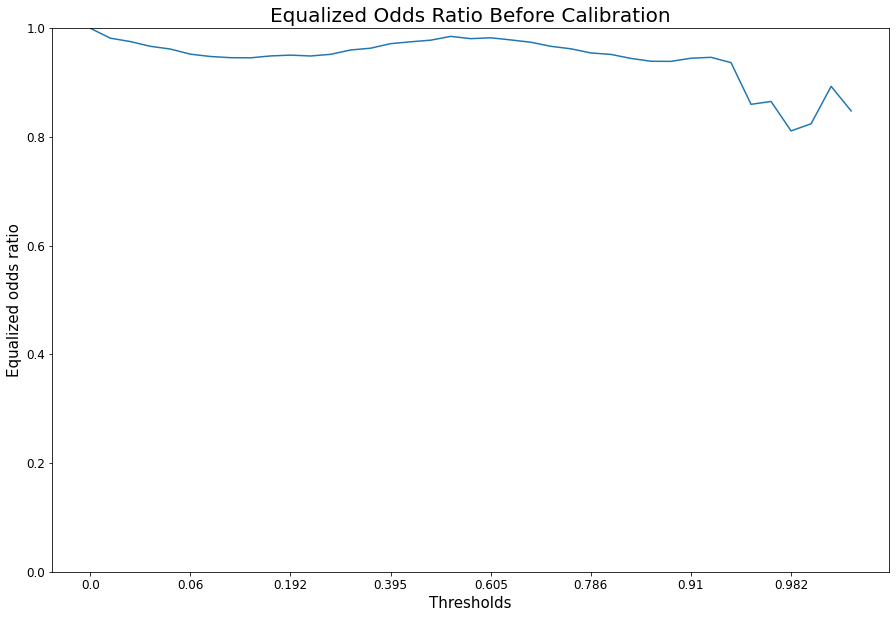

In [75]:
fig_odds_before = bias_results_df[(bias_results_df.METRIC == 'EQUALIZED_ODDS_RATIO') & (bias_results_df.CALIBRATION_STEP == 'BEFORE')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
fig_odds_before[:-1].T.drop_duplicates().T.plot(figsize=(15,10))
plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('Equalized odds ratio', fontsize = 15)
plt.ylim([0, 1])
plt.title('Equalized Odds Ratio Before Calibration', fontsize = 20)
plt.legend().remove()
plt.savefig('equalized_odds_ratio_before')

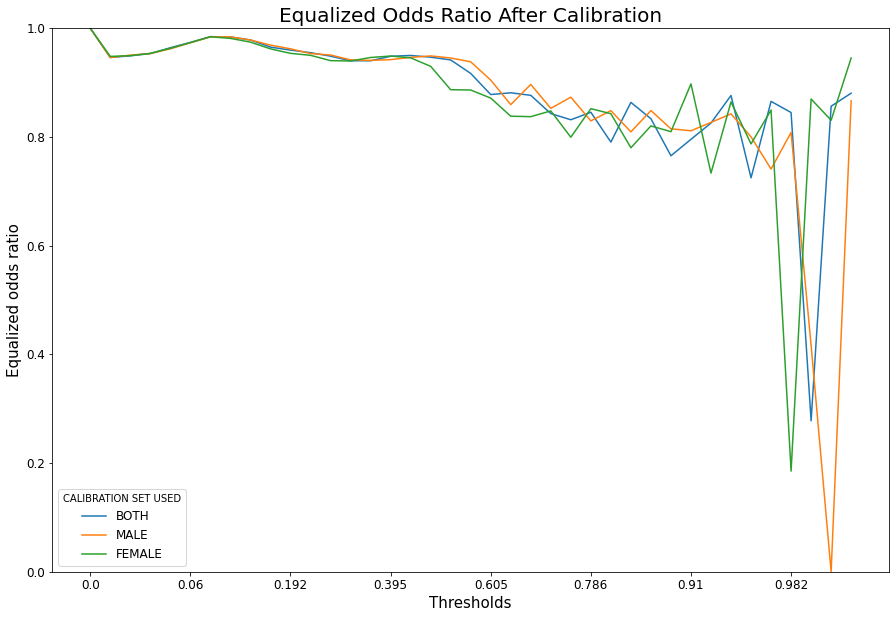

In [76]:
fig_odds_after = bias_results_df[(bias_results_df.METRIC == 'EQUALIZED_ODDS_RATIO') & (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
fig_odds_after[:-1].plot(figsize=(15,10))
plt.legend(fig_odds_after.iloc[-1].unique(), prop={'size': 12},title="CALIBRATION SET USED")
plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylim([0, 1])
plt.ylabel('Equalized odds ratio', fontsize = 15)
plt.title('Equalized Odds Ratio After Calibration', fontsize = 20)
plt.savefig('equalized_odds_ratio_after')

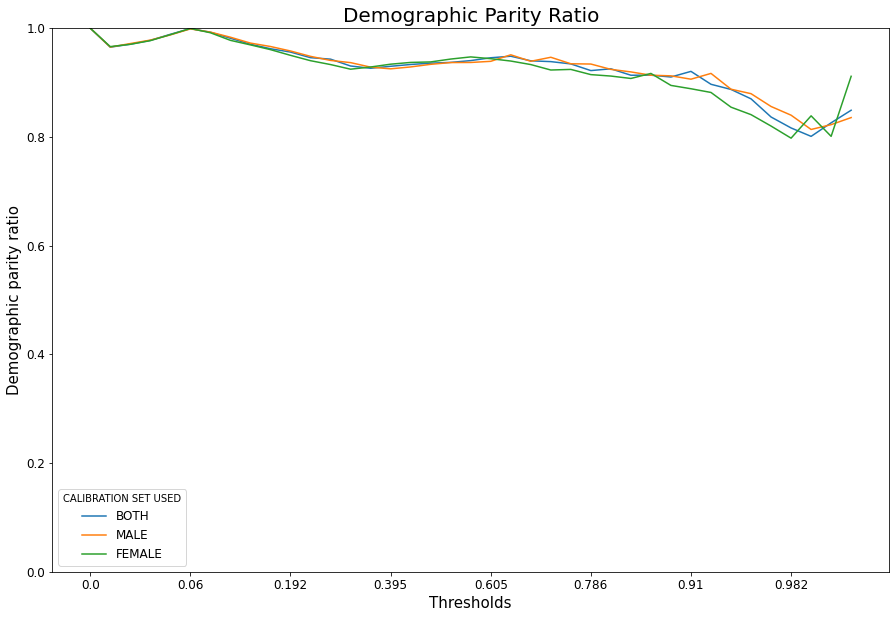

In [77]:
fig_odds_after = bias_results_df[(bias_results_df.METRIC == 'DEMOGRAPHIC_PARITY_RATIO') & (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
fig_odds_after[:-1].plot(figsize=(15,10))
plt.legend(fig_odds_after.iloc[-1].unique(), prop={'size': 12},title="CALIBRATION SET USED")
plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylim(0,1)
plt.ylabel('Demographic parity ratio', fontsize = 15)
plt.title('Demographic Parity Ratio', fontsize = 20)
plt.savefig('demographic_parity_ratio')

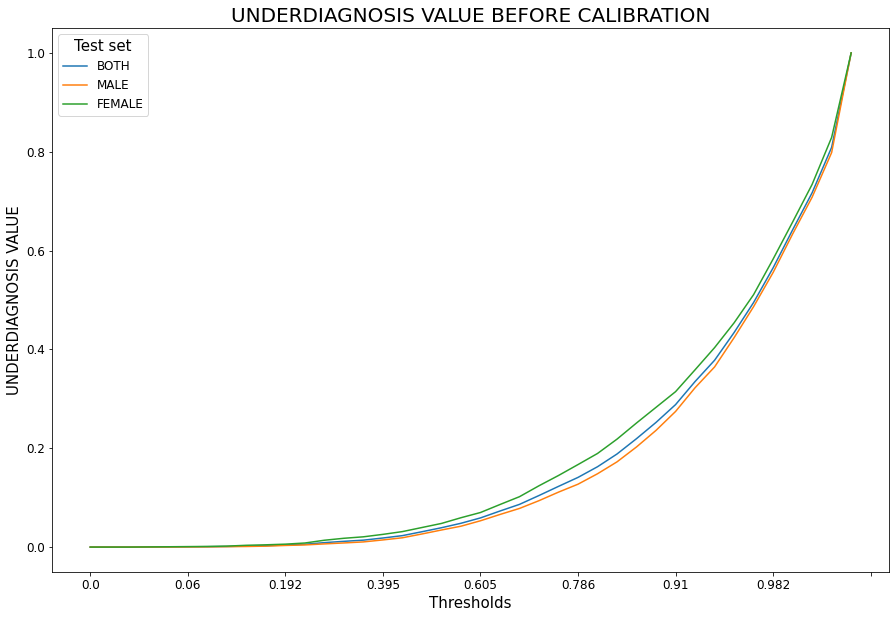

In [78]:
figure_df_both_all_bef_under = bias_results_df[(bias_results_df.METRIC == 'ALL_UNDERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'BOTH')& (bias_results_df.CALIBRATION_STEP == 'BEFORE')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_male_male_bef_under = bias_results_df[(bias_results_df.METRIC == 'MALE_UNDERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'MALE')& (bias_results_df.CALIBRATION_STEP == 'BEFORE')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_female_female_bef_under = bias_results_df[(bias_results_df.METRIC == 'FEMALE_UNDERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'FEMALE')& (bias_results_df.CALIBRATION_STEP == 'BEFORE')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T

ax = figure_df_both_all_bef_under[:-1].plot(figsize=(15,10))
figure_df_male_male_bef_under[:-1].plot(ax = ax)
figure_df_female_female_bef_under[:-1].plot(ax = ax)

plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('UNDERDIAGNOSIS VALUE', fontsize = 15)
plt.title('UNDERDIAGNOSIS VALUE BEFORE CALIBRATION', fontsize = 20)
legend_labels = ['BOTH', 'MALE', 'FEMALE']
legend = plt.legend(legend_labels, prop={'size': 12}, title ='Test set')
legend.get_title().set_fontsize('15')
plt.savefig('underdiagnosis_before_calibration')
#plt.axvline(x = thresholds_after_calib['specific'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold after')

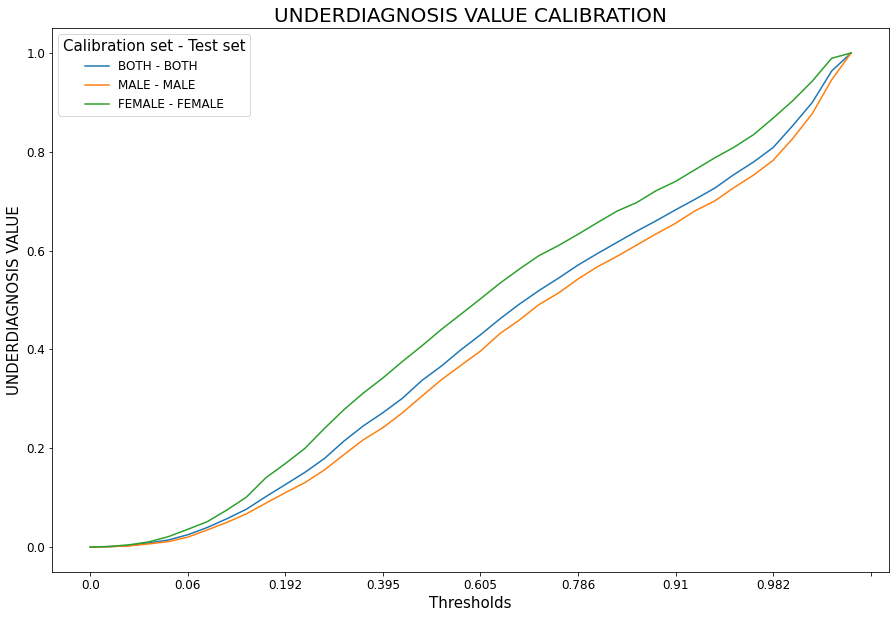

In [79]:
figure_df_both_all_under = bias_results_df[(bias_results_df.METRIC == 'ALL_UNDERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'BOTH')& (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_male_male_under = bias_results_df[(bias_results_df.METRIC == 'MALE_UNDERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'MALE')& (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_female_female_under = bias_results_df[(bias_results_df.METRIC == 'FEMALE_UNDERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'FEMALE')& (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T

ax = figure_df_both_all_under[:-1].plot(figsize=(15,10))
figure_df_male_male_under[:-1].plot(ax = ax)
figure_df_female_female_under[:-1].plot(ax = ax)

plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('UNDERDIAGNOSIS VALUE', fontsize = 15)
plt.title('UNDERDIAGNOSIS VALUE CALIBRATION', fontsize = 20)
legend_labels = ['BOTH - BOTH', 'MALE - MALE', 'FEMALE - FEMALE']
legend = plt.legend(legend_labels, prop={'size': 12}, title ='Calibration set - Test set')
legend.get_title().set_fontsize('15')
plt.savefig('underdiagnosis')
#plt.axvline(x = thresholds_after_calib['specific'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold after')

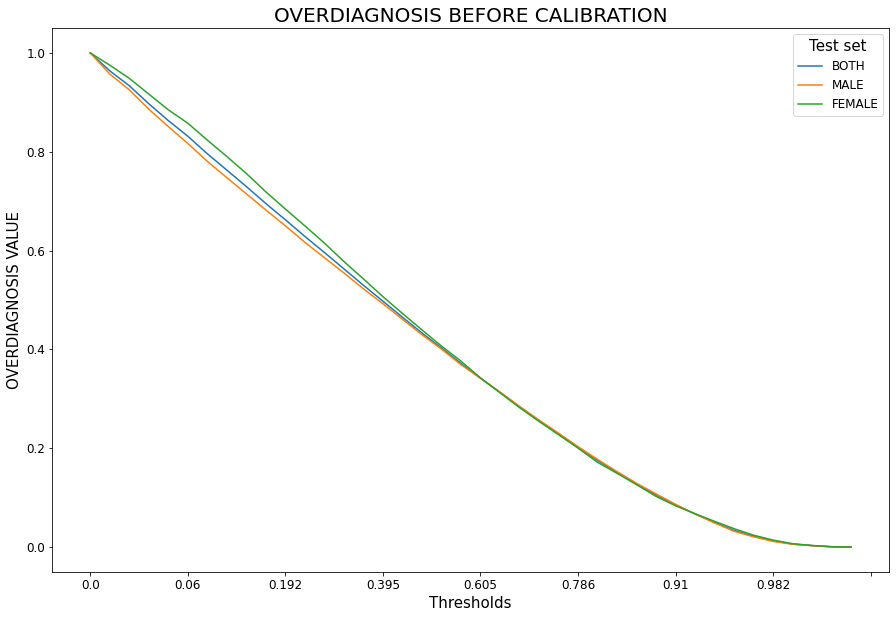

In [80]:
figure_df_both_all_bef_over = bias_results_df[(bias_results_df.METRIC == 'ALL_OVERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'BOTH')& (bias_results_df.CALIBRATION_STEP == 'BEFORE')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_male_male_bef_over = bias_results_df[(bias_results_df.METRIC == 'MALE_OVERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'MALE')& (bias_results_df.CALIBRATION_STEP == 'BEFORE')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_female_female_bef_over = bias_results_df[(bias_results_df.METRIC == 'FEMALE_OVERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'FEMALE')& (bias_results_df.CALIBRATION_STEP == 'BEFORE')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T

ax = figure_df_both_all_bef_over[:-1].plot(figsize=(15,10))
figure_df_male_male_bef_over[:-1].plot(ax = ax)
figure_df_female_female_bef_over[:-1].plot(ax = ax)

plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('OVERDIAGNOSIS VALUE', fontsize = 15)
plt.title('OVERDIAGNOSIS BEFORE CALIBRATION', fontsize = 20)
legend_labels = ['BOTH', 'MALE', 'FEMALE']
legend = plt.legend(legend_labels, prop={'size': 12}, title ='Test set')
legend.get_title().set_fontsize('15')
plt.savefig('overdiagnosis_before_calibration')
#plt.axvline(x = thresholds_after_calib['specific'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold after')

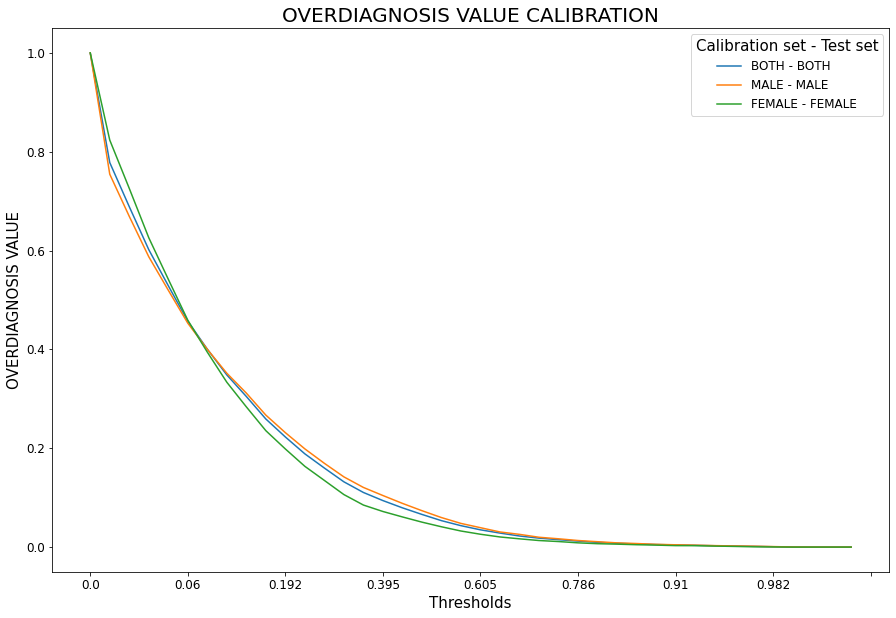

In [81]:
figure_df_both_all_over = bias_results_df[(bias_results_df.METRIC == 'ALL_OVERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'BOTH')& (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_male_male_over = bias_results_df[(bias_results_df.METRIC == 'MALE_OVERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'MALE')& (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T
figure_df_female_female_over = bias_results_df[(bias_results_df.METRIC == 'FEMALE_OVERDIAGNOSIS') & (bias_results_df.DATA_TO_CALIBRATE == 'FEMALE')& (bias_results_df.CALIBRATION_STEP == 'AFTER')].drop(columns = ['CALIBRATION_STEP', 'METRIC']).T

ax = figure_df_both_all_over[:-1].plot(figsize=(15,10))
figure_df_male_male_over[:-1].plot(ax = ax)
figure_df_female_female_over[:-1].plot(ax = ax)

plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('OVERDIAGNOSIS VALUE', fontsize = 15)
plt.title('OVERDIAGNOSIS VALUE CALIBRATION', fontsize = 20)
legend_labels = ['BOTH - BOTH', 'MALE - MALE', 'FEMALE - FEMALE']
legend = plt.legend(legend_labels, prop={'size': 12}, title ='Calibration set - Test set')
legend.get_title().set_fontsize('15')
plt.savefig('overdiagnosis')
#plt.axvline(x = thresholds_after_calib['specific'], ymin = 0, ymax = 1, color = 'r', label = 'PPV25 threshold after')

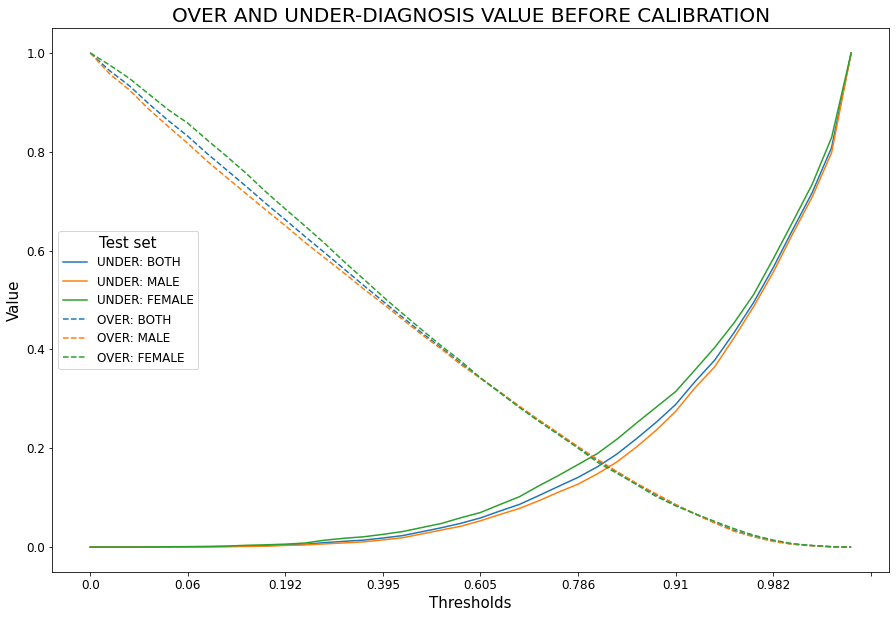

In [82]:
ax = figure_df_both_all_bef_under[:-1].plot(figsize=(15,10), color = '#1f77b4')
figure_df_male_male_bef_under[:-1].plot(ax = ax, color = '#ff7f0e')
figure_df_female_female_bef_under[:-1].plot(ax = ax, color = '#2ca02c')

figure_df_both_all_bef_over[:-1].plot(ax = ax, color = '#1f77b4', linestyle='--')
figure_df_male_male_bef_over[:-1].plot(ax = ax, color = '#ff7f0e',linestyle='--')
figure_df_female_female_bef_over[:-1].plot(ax = ax, color = '#2ca02c', linestyle='--')

plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('Value', fontsize = 15)
plt.title('OVER AND UNDER-DIAGNOSIS VALUE BEFORE CALIBRATION', fontsize = 20)
legend_labels = ['UNDER: BOTH', 'UNDER: MALE', 'UNDER: FEMALE', 'OVER: BOTH', 'OVER: MALE', 'OVER: FEMALE']
legend = plt.legend(legend_labels, prop={'size': 12}, title ='Test set')
legend.get_title().set_fontsize('15')
plt.savefig('over_underdiagnosis_before_calibration')

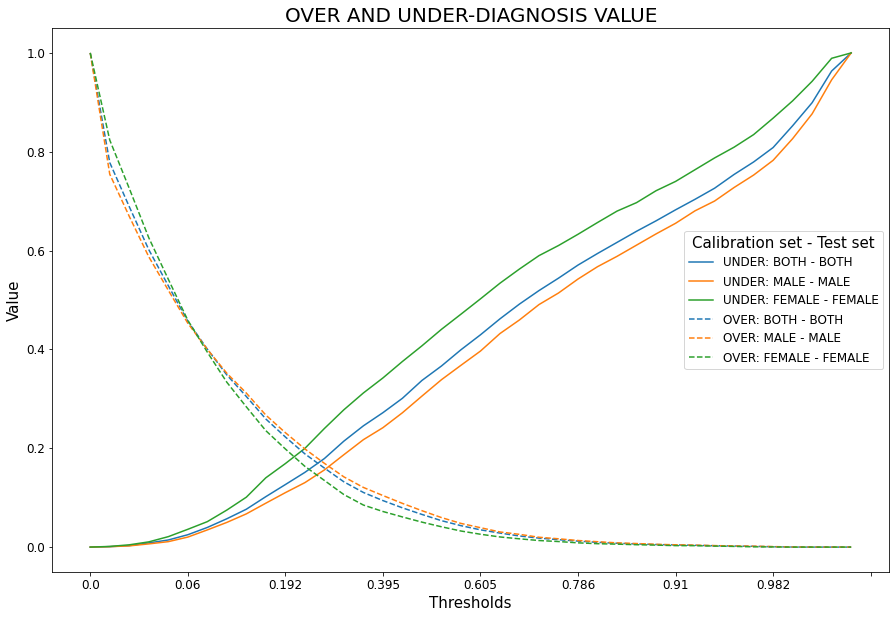

In [83]:
ax = figure_df_both_all_under[:-1].plot(figsize=(15,10), color = '#1f77b4')
figure_df_male_male_under[:-1].plot(ax = ax, color = '#ff7f0e')
figure_df_female_female_under[:-1].plot(ax = ax, color = '#2ca02c')

figure_df_both_all_over[:-1].plot(ax = ax, color = '#1f77b4', linestyle='--')
figure_df_male_male_over[:-1].plot(ax = ax, color = '#ff7f0e',linestyle='--')
figure_df_female_female_over[:-1].plot(ax = ax, color = '#2ca02c', linestyle='--')

plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('Value', fontsize = 15)
plt.title('OVER AND UNDER-DIAGNOSIS VALUE', fontsize = 20)
legend_labels = ['UNDER: BOTH - BOTH', 'UNDER: MALE - MALE', 'UNDER: FEMALE - FEMALE', 'OVER: BOTH - BOTH', 'OVER: MALE - MALE', 'OVER: FEMALE - FEMALE']
legend = plt.legend(legend_labels, prop={'size': 12}, title ='Calibration set - Test set')
legend.get_title().set_fontsize('15')
plt.savefig('over_underdiagnosis')

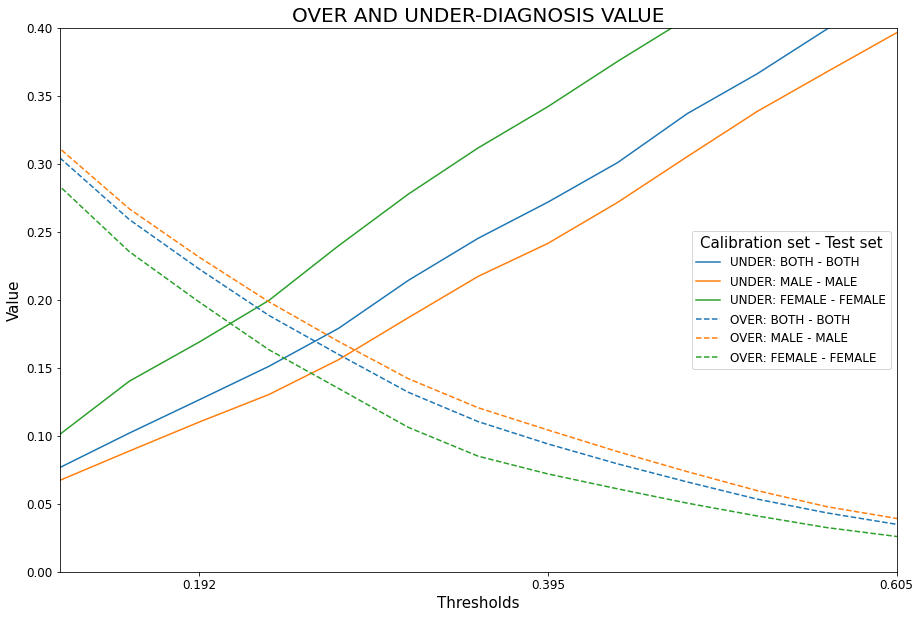

In [84]:
ax = figure_df_both_all_under[:-1].plot(figsize=(15,10), color = '#1f77b4')
figure_df_male_male_under[:-1].plot(ax = ax, color = '#ff7f0e')
figure_df_female_female_under[:-1].plot(ax = ax, color = '#2ca02c')

figure_df_both_all_over[:-1].plot(ax = ax, color = '#1f77b4', linestyle='--')
figure_df_male_male_over[:-1].plot(ax = ax, color = '#ff7f0e',linestyle='--')
figure_df_female_female_over[:-1].plot(ax = ax, color = '#2ca02c', linestyle='--')

plt.xticks(fontsize=12)
plt.xlabel('Thresholds', fontsize = 15)
plt.yticks(fontsize=12)
plt.ylabel('Value', fontsize = 15)
plt.title('OVER AND UNDER-DIAGNOSIS VALUE', fontsize = 20)
plt.xlim([8, 20])
plt.ylim([0, 0.4])
legend_labels = ['UNDER: BOTH - BOTH', 'UNDER: MALE - MALE', 'UNDER: FEMALE - FEMALE', 'OVER: BOTH - BOTH', 'OVER: MALE - MALE', 'OVER: FEMALE - FEMALE']
legend = plt.legend(legend_labels, prop={'size': 12}, title ='Calibration set - Test set')
legend.get_title().set_fontsize('15')
plt.savefig('over_underdiagnosis_zoom')

In [110]:
test_pred_both.to_csv('test_pred_both.csv', sep = ';',index_label=False)

## Decision curve

In [111]:
test_pred_both = pd.read_csv('test_pred_both.csv', sep = ';')

In [112]:
test_pred_both

,CASEID,LABEL,PREDICTION,OBS,PREDICTION_AFTER_CALIB,data,DATA_TO_CALIBRATE,GENDER
0,1364742,0,0.360764,GENDER-MALE AGE_GROUP-6 MEMO_ICD-N19 MEMO_ICD-...,0.044117,TEST,BOTH,BOTH
1,1369052,1,0.780920,GENDER-MALE AGE_GROUP-7 MEMO_ICD-J90 MEMO_ICD-...,0.209181,TEST,BOTH,BOTH
2,1384756,0,0.659102,MEMO_ICD-I63.9 GENDER-FEMALE AGE_GROUP-4 MEMO_...,0.129053,TEST,BOTH,BOTH
3,1391124,0,0.073599,MEMO_ICD-I63.9 MEMO_ICD-I34.0 LAB_RESULT-ERYTH...,0.007153,TEST,BOTH,BOTH
4,1392168,0,0.848883,GENDER-MALE AGE_GROUP-6 MEMO_ICD-R53 MEMO_ICD-...,0.289251,TEST,BOTH,BOTH
...,...,...,...,...,...,...,...,...
33200,1906019,0,0.876697,GENDER-MALE AGE_GROUP-7 MEMO_ICD-L98.9 LAB_RES...,0.337201,TEST,BOTH,BOTH
33201,1906136,0,0.648442,GENDER-MALE AGE_GROUP-5 MEMO_ICD-I25.14 MEMO_I...,0.124120,TEST,BOTH,BOTH
33202,1906175,1,0.356635,GENDER-MALE AGE_GROUP-7 ICD_HISTORICAL-I50.13 ...,0.043406,TEST,BOTH,BOTH
33203,1906177,0,0.236954,GENDER-MALE AGE_GROUP-5 LAB_RESULT-ERYTHROCYTE...,0.025539,TEST,BOTH,BOTH


In [113]:
female_df = test_pred_both[test_pred_both.OBS.str.contains('-FEMALE')]
male_df = test_pred_both[test_pred_both.OBS.str.contains('-MALE')]


In [114]:
#female_df = test_pred_fem
#male_df = test_pred_male

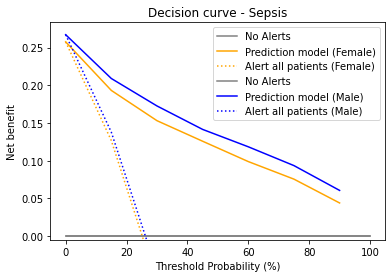

In [115]:
#Calculate the net benefit of our model and the strategy of alerts all
step = 0.15
prob = np.arange(0, 1, step).tolist()
gender_ticket = ['Female', 'Male']
gender_color = ['orange', 'blue']
#iso_pre = iso_pre_new
i = 0
for gender in [female_df,male_df]:
    net_benefit = []
    alert_all = []
    for p in prob:
        pred_labels = np.where(gender.PREDICTION_AFTER_CALIB >= p,1,0)
        tn, fp, fn, tp = confusion_matrix(gender.LABEL, pred_labels).ravel()
        n = len(gender.PREDICTION_AFTER_CALIB)
        net_benefit.append((tp/n) - (fp/n)*(p/(1-p)))
        alert_all.append(((tp+fn)/n) - ((fp+tn)/n)*(p/(1-p)))
        # plot the net benefits to get the decision curve
    plt.plot([0,100], [0,0], color = 'gray', label = 'No Alerts')
    plt.plot(np.multiply(prob,100)  , net_benefit, color = gender_color[i], label = f'Prediction model ({gender_ticket[i]})')
    plt.plot(np.multiply(prob,100)[:3], alert_all[:3],color = gender_color[i],linestyle='dotted', label = f'Alert all patients ({gender_ticket[i]})')
    i= i+1
plt.xlabel("Threshold Probability (%)")
plt.ylabel("Net benefit")
plt.title('Decision curve - Sepsis')
plt.ylim(bottom=-0.005) 
plt.legend()